In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Preprocessing du dataset annoté de Outahajala, output : labeledData.csv

In [ ]:
import pandas as pd

# Charger le fichier CSV
file_path = "labeledData.29.tags - Copie.2col_WORD-POS.csv"

# Charger le fichier CSV en supposant qu'il a deux colonnes
df = pd.read_csv(file_path, sep=" ", header=None, names=["word", "tag"], encoding="utf-8")

# Dictionnaire de remplacement des caractères
replacements = {
    "g°": "gʷ",
    "k°": "kʷ",
    "G": "ɣ",
    "D": "ḍ",
    "T": "ṭ",
    "H": "ḥ",
    "E": "ɛ",
    "R": "ṛ",
    "S": "ṣ",
    "Z": "ẓ",
    "W": "w",
    "ţ": "t",
    "Ţ": "T",
    "dj": "ǧǧ",
    "tc": "čč",
    "Σ": "Ɛ"
}

# Appliquer les remplacements à la première colonne (les mots)
df["word"] = df["word"].replace(replacements, regex=True)

# Sauvegarder le fichier modifié
output_file_path = "labeledData.csv"
df.to_csv(output_file_path, index=False, header=True)

# Afficher les 5 premières lignes pour vérification
df.head()


word  tag
0  asfuglu   NN
1        n    S
2  usggwas   NN
3   amaziɣ  ADJ
4        s    S

# Annotation rapide en utilisant un speech recognition tool

In [ ]:
import pandas as pd

# Liste des tags attendus (en minuscules pour comparaison)
tag_mapping = {
    "common noun": "NN",
    "proper noun": "NNP",
    "verb base form": "VB",
    "verb participle": "VBP",
    "adjective": "ADJ",
    "adverb": "ADV",
    "conjunction": "C",
    "date": "DATE",
    "determiner": "DT",
    "focalizer": "FOC",
    "interjection": "IN",
    "interrogative": "INT",
    "particle negative": "NEG",
    "numeral": "NUM",
    "demonstrative pronoun": "PDEM",
    "particle predicate": "PRED",
    "personal pronoun": "PP",
    "personal possessive": "PPOS",
    "particle orientation": "PROR",
    "particle preverbal": "PRPR",
    "particle other": "PROT",
    "relative": "REL",
    "residual other": "ROT",
    "preposition": "S",
    "vocative": "VOC",
    #"foreign word": "FW",
    "punctuation": "PUNC",
    "preposition followed by personal pronoun" : "S_PP",
    "kinship noun followed by personal pronoun" : "NNK_PP"
}

# Liste des tags sous forme de set pour reconnaissance rapide
tag_list = sorted(tag_mapping.keys(), key=lambda x: -len(x.split()))  # Trie par longueur décroissante

# Lecture du fichier text.txt (mots séparés par espace)
with open("wikiTACtest.txt", "r", encoding="utf-8") as f:
    words = f.read().strip().split()  # Découpe en mots

# Lecture du fichier tags.txt (phrase unique contenant les tags)
with open("wikiTACtags.txt", "r", encoding="utf-8") as f:
    tag_string = f.read().strip().lower()

# Algorithme pour découper les tags correctement
tags = []
while tag_string:
    found = False
    for tag in tag_list:
        if tag_string.startswith(tag):
            tags.append(tag)
            tag_string = tag_string[len(tag):].strip()  # Supprime le tag trouvé
            found = True
            break
    if not found:  # Cas d'erreur (tag inconnu)
        raise ValueError(f"Erreur: Impossible de reconnaître le tag à partir de '{tag_string}'")

# Vérification du nombre d'éléments
if len(words) != len(tags):
    raise ValueError(f"Erreur: {len(words)} mots et {len(tags)} tags trouvés. Ils doivent être en nombre égal.")

# Remplacement des tags par leurs codes POS
converted_tags = [tag_mapping[tag] for tag in tags]

# Création du DataFrame
df = pd.DataFrame({"Word": words, "Tag": converted_tags})

# Sauvegarde en CSV
df.to_csv("wikiTACannotated_dataset.csv", index=False, encoding="utf-8")

print("✅ Fichier 'annotated_dataset.csv' généré avec succès !")


✅ Fichier 'annotated_dataset.csv' généré avec succès !


# Scraping des textes Wikipedia en utilisant l'API

In [ ]:
import requests
import re
import nltk
import os

# Titre de l'article Wikipédia
title = "Vasilisa Tafalkayt"

# Préparer la requête
url = "https://shi.wikipedia.org/w/api.php"
params = {
    "action": "query",
    "format": "json",
    "titles": title,
    "prop": "extracts",
    "explaintext": True
}

# Récupérer l'article
response = requests.get(url, params=params)
data = response.json()
page = next(iter(data["query"]["pages"].values()))
text = page["extract"]

# Nettoyage du texte
clean_text = re.sub(r'={2,}(.+?)={2,}', r'\1', text)

# Nettoyage du nom de fichier à partir du titre
filename = re.sub(r'[^\w\s-]', '', title)  # Supprime caractères spéciaux
filename = filename.replace(' ', '_') + ".txt"

# Écriture dans un fichier
with open(filename, "w", encoding="utf-8") as f:
    f.write(clean_text)

# Charger le texte pour tokenisation
with open(filename, "r", encoding="utf-8") as f:
    raw_text = f.read()

# Tokenisation
nltk.download('punkt')
tokenized_text = nltk.word_tokenize(raw_text)

print("Nombre de tokens :", len(tokenized_text))


Nombre de tokens : 4067


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Recherche des pages Wikipedia en kabyle et en tachelhit

In [ ]:
import requests
import nltk
nltk.download("punkt")
from nltk.tokenize import word_tokenize

headers = {
    "User-Agent": "Mozilla/5.0 (compatible; TokenCounterBot/1.0)"
}

url = "https://shi.wikipedia.org/w/api.php"
token_counts = []
seen = 0
MAX_PAGES = 1000  # Tu peux augmenter à 1000+ selon le temps disponible

apcontinue = None
while True:
    # Paramètres de base
    params = {
        "action": "query",
        "format": "json",
        "list": "allpages",
        "aplimit": 100,
        "apminsize": 10000
    }
    if apcontinue:
        params["apcontinue"] = apcontinue

    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    pages = data["query"]["allpages"]

    for page in pages:
        title = page["title"]

        extract_params = {
            "action": "query",
            "format": "json",
            "prop": "extracts",
            "explaintext": True,
            "titles": title
        }

        extract_response = requests.get(url, params=extract_params, headers=headers)
        if extract_response.status_code != 200:
            continue

        try:
            extract_data = extract_response.json()
            page_data = next(iter(extract_data["query"]["pages"].values()))
            extract_text = page_data.get("extract", "")
        except Exception:
            continue

        if not extract_text.strip():
            continue

        tokens = word_tokenize(extract_text)
        token_counts.append((title, page_data["pageid"], len(tokens)))

        seen += 1
        if seen >= MAX_PAGES:
            break

    # Poursuite de la pagination
    if seen >= MAX_PAGES:
        break
    if "continue" in data:
        apcontinue = data["continue"]["apcontinue"]
    else:
        break

# Tri final
sorted_pages = sorted(token_counts, key=lambda x: x[2], reverse=True)

print("\n📚 Top pages classées par nombre de tokens :")
for title, pageid, count in sorted_pages[:10]:
    print(f"{title} (Page ID: {pageid}) → {count} tokens")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



📚 Top pages classées par nombre de tokens :
Mrrakc (Page ID: 4268) → 17807 tokens
Tutlayt Taclḥiyt (Page ID: 2417) → 8494 tokens
Lɛammt (Page ID: 4127) → 5321 tokens
Timdinin n Lmɣrib (Page ID: 2326) → 4821 tokens
Lmɣrib (Page ID: 1838) → 4416 tokens
Aḥwac n taskiwin (Page ID: 3692) → 4375 tokens
Muḥmmad Albnsir (Page ID: 1920) → 4263 tokens
Anwal n Usammr (Page ID: 4275) → 4197 tokens
Vasilisa Tafalkayt (Page ID: 2497) → 4071 tokens
Timskarin n ubuy (Page ID: 4178) → 3895 tokens


# Good version

## GRU

### Sans le weighting

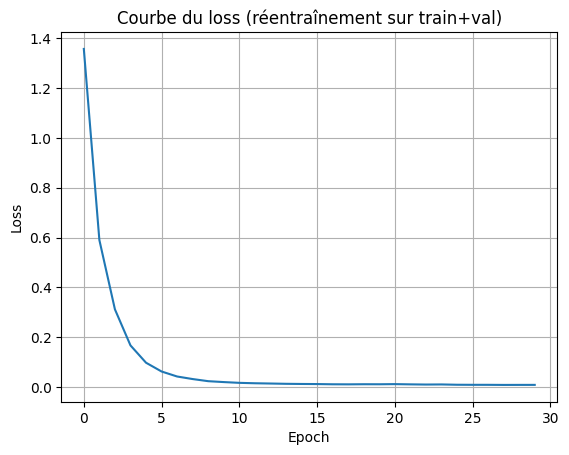

Meilleure configuration :
   embedding_dim  hidden_dim     lr  epochs  val_accuracy  \
0            200         128  0.005      30      0.827532   

                                              losses  test_accuracy  
0  [1.4781794518232345, 0.6643186673521996, 0.355...       0.847716  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import product
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# === Chargement et chunking ===
df = pd.read_csv("labeledData_fixed.csv")
MAX_LEN = 20

def chunk_dataset(df, max_len=20):
    words = df['word'].tolist()
    tags = df['tag'].tolist()
    sequences = []
    for i in range(0, len(words), max_len):
        w_chunk = words[i:i + max_len]
        t_chunk = tags[i:i + max_len]
        sequences.append((w_chunk, t_chunk))
    return sequences

chunks = chunk_dataset(df, MAX_LEN)
train_val_chunks, test_chunks = train_test_split(chunks, test_size=0.2, random_state=2)
train_chunks, val_chunks = train_test_split(train_val_chunks, test_size=0.2, random_state=2)

# === Vocab et tags ===
word_to_ix = {word: i+1 for i, word in enumerate(sorted(set(df["word"])))}
tag_to_ix = {tag: i for i, tag in enumerate(sorted(set(df["tag"])))}
ix_to_tag = {i: tag for tag, i in tag_to_ix.items()}

# === Dataset et Dataloader ===
class POSDataset(Dataset):
    def __init__(self, sequences, word_to_ix, tag_to_ix, max_len):
        self.sequences = sequences
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        words, tags = self.sequences[idx]
        word_ids = [self.word_to_ix.get(w, 0) for w in words]
        tag_ids = [self.tag_to_ix[t] for t in tags]

        pad_len = self.max_len - len(word_ids)
        word_ids += [0] * pad_len
        tag_ids += [-100] * pad_len

        return torch.tensor(word_ids), torch.tensor(tag_ids)

def get_loaders(train_data, val_data, word_to_ix, tag_to_ix, max_len, batch_size=16):
    train_ds = POSDataset(train_data, word_to_ix, tag_to_ix, max_len)
    val_ds = POSDataset(val_data, word_to_ix, tag_to_ix, max_len)
    return DataLoader(train_ds, batch_size=batch_size, shuffle=True), DataLoader(val_ds, batch_size=batch_size)

# === Modèle GRU ===
class POSGRU(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        return self.fc(x)

# === Entraînement + évaluation ===
def train_and_eval(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    model.to(device)
    losses = []

    for _ in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x).view(-1, model.fc.out_features)
            loss = criterion(out, y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / len(train_loader))

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            preds = model(x).argmax(dim=-1).cpu().view(-1)
            all_preds += preds.tolist()
            all_labels += y.view(-1).tolist()

    val_acc = accuracy_score([l for l in all_labels if l != -100],
                             [p for p, l in zip(all_preds, all_labels) if l != -100])
    return val_acc, losses

# === Recherche des meilleurs hyperparamètres ===
embedding_dims = [100, 200]
hidden_dims = [128, 256]
learning_rates = [0.005, 0.01]
epochs_list = [10, 20, 30, 40, 50]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(word_to_ix) + 1
tagset_size = len(tag_to_ix)

train_loader, val_loader = get_loaders(train_chunks, val_chunks, word_to_ix, tag_to_ix, MAX_LEN)
results = []

for emb, hid, lr, ep in product(embedding_dims, hidden_dims, learning_rates, epochs_list):
    model = POSGRU(vocab_size, tagset_size, emb, hid)
    optim_ = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    acc, losses = train_and_eval(model, train_loader, val_loader, optim_, loss_fn, device, ep)
    results.append({
        "embedding_dim": emb, "hidden_dim": hid, "lr": lr,
        "epochs": ep, "val_accuracy": acc, "losses": losses
    })

# === Meilleure config ===
best = max(results, key=lambda x: x["val_accuracy"])
full_train = train_chunks + val_chunks
train_loader, test_loader = get_loaders(full_train, test_chunks, word_to_ix, tag_to_ix, MAX_LEN)

model = POSGRU(vocab_size, tagset_size, best["embedding_dim"], best["hidden_dim"])
optimizer = optim.Adam(model.parameters(), lr=best["lr"])
criterion = nn.CrossEntropyLoss(ignore_index=-100)
_, losses = train_and_eval(model, train_loader, test_loader, optimizer, criterion, device, best["epochs"])

model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        preds = model(x).argmax(dim=-1).cpu().view(-1)
        test_preds += preds.tolist()
        test_labels += y.view(-1).tolist()

test_acc = accuracy_score([l for l in test_labels if l != -100],
                          [p for p, l in zip(test_preds, test_labels) if l != -100])
best["test_accuracy"] = test_acc

# === Courbe du loss final ===
plt.plot(losses)
plt.title("Courbe du loss (réentraînement sur train+val)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Résumé final
import pandas as pd
print("Meilleure configuration :")
print(pd.DataFrame([best]))


### Avec le weighting

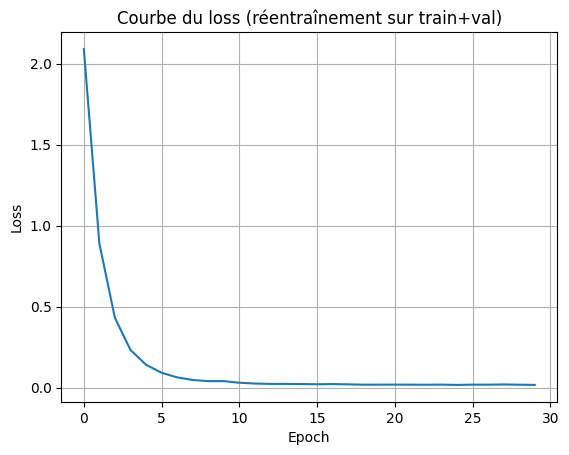

Meilleure configuration :
   embedding_dim  hidden_dim     lr  epochs  val_accuracy  \
0            200         128  0.005      30      0.814557   

                                              losses  test_accuracy  
0  [2.2305418998003006, 0.9620205402374268, 0.461...       0.834772  

Classification report (par tag):
              precision    recall  f1-score   support

         ADJ      0.733     0.641     0.684       103
         ADV      0.557     0.587     0.571       109
           C      0.792     0.756     0.773       176
          DT      0.790     0.794     0.792       223
         FOC      0.524     0.611     0.564        18
          IN      0.833     0.455     0.588        11
         INT      0.381     0.615     0.471        13
         NEG      0.960     0.980     0.970        49
          NN      0.850     0.838     0.844       884
      NNK_PP      0.875     0.824     0.848        17
         NNP      0.658     0.676     0.667        74
         NUM      0.750     

In [ ]:
# === GRU avec class weighting + test + error analysis + per-class metrics ===

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from itertools import product
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torch.nn.functional as F
import random

random.seed(23)

# === Chargement et chunking ===
df = pd.read_csv("labeledData_fixed.csv")
MAX_LEN = 20

def chunk_dataset(df, max_len=20):
    words = df['word'].tolist()
    tags = df['tag'].tolist()
    sequences = []
    for i in range(0, len(words), max_len):
        w_chunk = words[i:i + max_len]
        t_chunk = tags[i:i + max_len]
        sequences.append((w_chunk, t_chunk))
    return sequences

chunks = chunk_dataset(df, MAX_LEN)
train_val_chunks, test_chunks = train_test_split(chunks, test_size=0.2, random_state=2)
train_chunks, val_chunks = train_test_split(train_val_chunks, test_size=0.2, random_state=2)

# === Vocab et tags ===
word_to_ix = {word: i+1 for i, word in enumerate(sorted(set(df["word"])))}
tag_to_ix = {tag: i for i, tag in enumerate(sorted(set(df["tag"])))}
ix_to_tag = {i: tag for tag, i in tag_to_ix.items()}

# === Poids de classes ===
tag_counts = Counter(df["tag"].tolist())
total = sum(tag_counts.values())
class_weights = [total / tag_counts[tag] for tag in tag_to_ix.keys()]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Dataset et Dataloader ===
class POSDataset(Dataset):
    def __init__(self, sequences, word_to_ix, tag_to_ix, max_len):
        self.sequences = sequences
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        words, tags = self.sequences[idx]
        word_ids = [self.word_to_ix.get(w, 0) for w in words]
        tag_ids = [self.tag_to_ix[t] for t in tags]

        pad_len = self.max_len - len(word_ids)
        word_ids += [0] * pad_len
        tag_ids += [-100] * pad_len

        return torch.tensor(word_ids), torch.tensor(tag_ids)

def get_loaders(train_data, val_data, word_to_ix, tag_to_ix, max_len, batch_size=16):
    train_ds = POSDataset(train_data, word_to_ix, tag_to_ix, max_len)
    val_ds = POSDataset(val_data, word_to_ix, tag_to_ix, max_len)
    return DataLoader(train_ds, batch_size=batch_size, shuffle=True), DataLoader(val_ds, batch_size=batch_size)

# === Modèle GRU ===
class POSGRU(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        return self.fc(x)

# === Entraînement + évaluation ===
def train_and_eval(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    model.to(device)
    losses = []

    for _ in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x).view(-1, model.fc.out_features)
            loss = criterion(out, y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / len(train_loader))

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            preds = model(x).argmax(dim=-1).cpu().view(-1)
            all_preds += preds.tolist()
            all_labels += y.view(-1).tolist()

    val_acc = accuracy_score([l for l in all_labels if l != -100],
                             [p for p, l in zip(all_preds, all_labels) if l != -100])
    return val_acc, losses

# === Recherche des meilleurs hyperparamètres ===
embedding_dims = [100, 200]
hidden_dims = [128, 256]
learning_rates = [0.005, 0.01]
epochs_list = [10, 20, 30, 40, 50]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(word_to_ix) + 1
tagset_size = len(tag_to_ix)
class_weights_tensor = class_weights_tensor.to(device)

train_loader, val_loader = get_loaders(train_chunks, val_chunks, word_to_ix, tag_to_ix, MAX_LEN)
results = []

for emb, hid, lr, ep in product(embedding_dims, hidden_dims, learning_rates, epochs_list):
    model = POSGRU(vocab_size, tagset_size, emb, hid)
    optim_ = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights_tensor)
    acc, losses = train_and_eval(model, train_loader, val_loader, optim_, loss_fn, device, ep)
    results.append({
        "embedding_dim": emb, "hidden_dim": hid, "lr": lr,
        "epochs": ep, "val_accuracy": acc, "losses": losses
    })

# === Meilleure config ===
best = max(results, key=lambda x: x["val_accuracy"])
full_train = train_chunks + val_chunks
train_loader, test_loader = get_loaders(full_train, test_chunks, word_to_ix, tag_to_ix, MAX_LEN)

model = POSGRU(vocab_size, tagset_size, best["embedding_dim"], best["hidden_dim"])
optimizer = optim.Adam(model.parameters(), lr=best["lr"])
criterion = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights_tensor)
_, losses = train_and_eval(model, train_loader, test_loader, optimizer, criterion, device, best["epochs"])

model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        preds = model(x).argmax(dim=-1).cpu().view(-1)
        test_preds += preds.tolist()
        test_labels += y.view(-1).tolist()

mask = [l != -100 for l in test_labels]
test_acc = accuracy_score([l for l in test_labels if l != -100],
                          [p for p, l in zip(test_preds, test_labels) if l != -100])
best["test_accuracy"] = test_acc

# === Courbe du loss final ===
plt.plot(losses)
plt.title("Courbe du loss (réentraînement sur train+val)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Résumé final
print("Meilleure configuration :")
print(pd.DataFrame([best]))

# === Per-class classification report ===
print("\nClassification report (par tag):")
print(classification_report(
    [ix_to_tag[l] for l in np.array(test_labels)[mask]],
    [ix_to_tag[p] for p, l in zip(test_preds, test_labels) if l != -100],
    digits=3
))

# === Error analysis sur test_chunks ===
print("\nError analysis : prédictions sur 2 phrases du test set")

sample_chunks = random.sample(test_chunks, 10)  # en prendre plusieurs pour en trouver une mauvaise
shown = 0
for words, true_tags in sample_chunks:
    word_ids = torch.tensor([word_to_ix.get(w, 0) for w in words]).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(word_ids)
        probs = F.softmax(logits, dim=-1).squeeze(0)
        preds = torch.argmax(probs, dim=-1).cpu().tolist()
        confs = torch.max(probs, dim=-1).values.cpu().tolist()

    pred_tags = [ix_to_tag[p] for p in preds[:len(words)]]
    errors = [(w, t, p) for w, t, p in zip(words, true_tags, pred_tags) if t != p]

    print("\n--- Phrase ---")
    for w, t, p, c in zip(words, true_tags, pred_tags, confs):
        print(f"{w:<12} | Vrai: {t:<8} | Prédit: {p:<8} | Confiance: {c:.2f}")

    if errors:
        shown += 1
    if shown >= 2:
        break


## LSTM

### Sans weighting

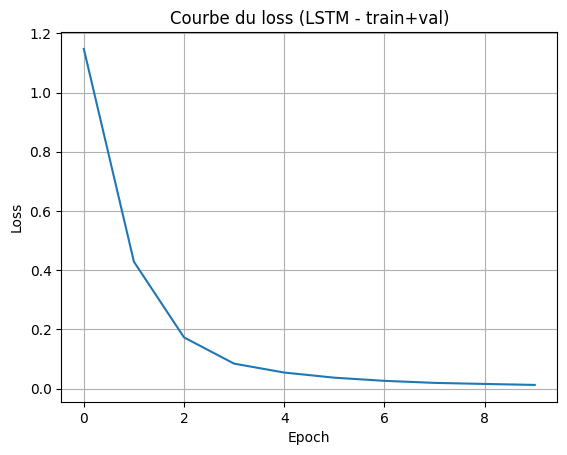


Meilleure configuration trouvée :
   embedding_dim  hidden_dim    lr  epochs  val_accuracy  \
0            200         256  0.01      10      0.835127   

                                              losses  test_accuracy  
0  [1.2783182546496392, 0.4673254765570164, 0.179...       0.858376  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import product
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# === Chargement et chunking ===
df = pd.read_csv("labeledData_fixed.csv")
MAX_LEN = 20

def chunk_dataset(df, max_len=20):
    words = df['word'].tolist()
    tags = df['tag'].tolist()
    sequences = []
    for i in range(0, len(words), max_len):
        w_chunk = words[i:i + max_len]
        t_chunk = tags[i:i + max_len]
        sequences.append((w_chunk, t_chunk))
    return sequences

chunks = chunk_dataset(df, MAX_LEN)
train_val_chunks, test_chunks = train_test_split(chunks, test_size=0.2, random_state=2)
train_chunks, val_chunks = train_test_split(train_val_chunks, test_size=0.2, random_state=2)

# === Vocab et tags ===
word_to_ix = {word: i+1 for i, word in enumerate(sorted(set(df["word"])))}
tag_to_ix = {tag: i for i, tag in enumerate(sorted(set(df["tag"])))}
ix_to_tag = {i: tag for tag, i in tag_to_ix.items()}

# === Dataset et Dataloader ===
class POSDataset(Dataset):
    def __init__(self, sequences, word_to_ix, tag_to_ix, max_len):
        self.sequences = sequences
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        words, tags = self.sequences[idx]
        word_ids = [self.word_to_ix.get(w, 0) for w in words]
        tag_ids = [self.tag_to_ix[t] for t in tags]

        pad_len = self.max_len - len(word_ids)
        word_ids += [0] * pad_len
        tag_ids += [-100] * pad_len

        return torch.tensor(word_ids), torch.tensor(tag_ids)

def get_loaders(train_data, val_data, word_to_ix, tag_to_ix, max_len, batch_size=16):
    train_ds = POSDataset(train_data, word_to_ix, tag_to_ix, max_len)
    val_ds = POSDataset(val_data, word_to_ix, tag_to_ix, max_len)
    return DataLoader(train_ds, batch_size=batch_size, shuffle=True), DataLoader(val_ds, batch_size=batch_size)

# === Modèle LSTM ===
class POSLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        return self.fc(x)

# === Entraînement + évaluation ===
def train_and_eval(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    model.to(device)
    losses = []

    for _ in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x).view(-1, model.fc.out_features)
            loss = criterion(out, y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / len(train_loader))

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            preds = model(x).argmax(dim=-1).cpu().view(-1)
            all_preds += preds.tolist()
            all_labels += y.view(-1).tolist()

    val_acc = accuracy_score([l for l in all_labels if l != -100],
                             [p for p, l in zip(all_preds, all_labels) if l != -100])
    return val_acc, losses

# === Grid Search ===
embedding_dims = [100, 200]
hidden_dims = [128, 256]
learning_rates = [0.005, 0.01]
epochs_list = [10, 20, 30, 40, 50]

vocab_size = len(word_to_ix) + 1
tagset_size = len(tag_to_ix)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = get_loaders(train_chunks, val_chunks, word_to_ix, tag_to_ix, MAX_LEN)

results = []
for emb, hid, lr, ep in product(embedding_dims, hidden_dims, learning_rates, epochs_list):
    model = POSLSTM(vocab_size, tagset_size, emb, hid)
    optim_ = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    acc, losses = train_and_eval(model, train_loader, val_loader, optim_, loss_fn, device, ep)
    results.append({"embedding_dim": emb, "hidden_dim": hid, "lr": lr, "epochs": ep, "val_accuracy": acc, "losses": losses})

# === Meilleure config ===
best = max(results, key=lambda x: x["val_accuracy"])
full_train = train_chunks + val_chunks
train_loader, test_loader = get_loaders(full_train, test_chunks, word_to_ix, tag_to_ix, MAX_LEN)

model = POSLSTM(vocab_size, tagset_size, best["embedding_dim"], best["hidden_dim"])
optimizer = optim.Adam(model.parameters(), lr=best["lr"])
criterion = nn.CrossEntropyLoss(ignore_index=-100)
_, losses = train_and_eval(model, train_loader, test_loader, optimizer, criterion, device, best["epochs"])

model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        preds = model(x).argmax(dim=-1).cpu().view(-1)
        test_preds += preds.tolist()
        test_labels += y.view(-1).tolist()

test_acc = accuracy_score([l for l in test_labels if l != -100],
                          [p for p, l in zip(test_preds, test_labels) if l != -100])
best["test_accuracy"] = test_acc

# === Courbe du loss final ===
plt.plot(losses)
plt.title("Courbe du loss (LSTM - train+val)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("\nMeilleure configuration trouvée :")
print(pd.DataFrame([best]))


### Avec weighting

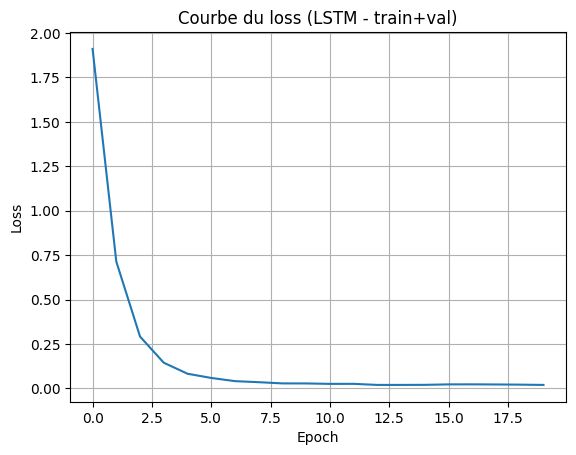


Meilleure configuration trouvée :
   embedding_dim  hidden_dim    lr  epochs  val_accuracy  \
0            200         128  0.01      20       0.82057   

                                              losses  test_accuracy  
0  [2.0137495785951613, 0.7478146344423294, 0.286...       0.825127  

📊 Classification report (par tag):
              precision    recall  f1-score   support

         ADJ      0.737     0.709     0.723       103
         ADV      0.573     0.578     0.575       109
           C      0.793     0.739     0.765       176
          DT      0.694     0.794     0.741       223
         FOC      0.435     0.556     0.488        18
          IN      0.300     0.273     0.286        11
         INT      0.421     0.615     0.500        13
         NEG      0.923     0.980     0.950        49
          NN      0.845     0.830     0.837       884
      NNK_PP      0.700     0.824     0.757        17
         NNP      0.634     0.703     0.667        74
         NUM      0

In [ ]:
# === LSTM avec class weighting + test + error analysis + per-class metrics ===

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from itertools import product
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torch.nn.functional as F
import random

random.seed(23)

# === Chargement et chunking ===
df = pd.read_csv("labeledData_fixed.csv")
MAX_LEN = 20

def chunk_dataset(df, max_len=20):
    words = df['word'].tolist()
    tags = df['tag'].tolist()
    sequences = []
    for i in range(0, len(words), max_len):
        w_chunk = words[i:i + max_len]
        t_chunk = tags[i:i + max_len]
        sequences.append((w_chunk, t_chunk))
    return sequences

chunks = chunk_dataset(df, MAX_LEN)
train_val_chunks, test_chunks = train_test_split(chunks, test_size=0.2, random_state=2)
train_chunks, val_chunks = train_test_split(train_val_chunks, test_size=0.2, random_state=2)

# === Vocab et tags ===
word_to_ix = {word: i+1 for i, word in enumerate(sorted(set(df["word"])))}
tag_to_ix = {tag: i for i, tag in enumerate(sorted(set(df["tag"])))}
ix_to_tag = {i: tag for tag, i in tag_to_ix.items()}

# === Poids de classes ===
tag_counts = Counter(df["tag"].tolist())
total = sum(tag_counts.values())
class_weights = [total / tag_counts[tag] for tag in tag_to_ix.keys()]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Dataset et Dataloader ===
class POSDataset(Dataset):
    def __init__(self, sequences, word_to_ix, tag_to_ix, max_len):
        self.sequences = sequences
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        words, tags = self.sequences[idx]
        word_ids = [self.word_to_ix.get(w, 0) for w in words]
        tag_ids = [self.tag_to_ix[t] for t in tags]

        pad_len = self.max_len - len(word_ids)
        word_ids += [0] * pad_len
        tag_ids += [-100] * pad_len

        return torch.tensor(word_ids), torch.tensor(tag_ids)

def get_loaders(train_data, val_data, word_to_ix, tag_to_ix, max_len, batch_size=16):
    train_ds = POSDataset(train_data, word_to_ix, tag_to_ix, max_len)
    val_ds = POSDataset(val_data, word_to_ix, tag_to_ix, max_len)
    return DataLoader(train_ds, batch_size=batch_size, shuffle=True), DataLoader(val_ds, batch_size=batch_size)

# === Modèle LSTM ===
class POSLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        return self.fc(x)

# === Entraînement + évaluation ===
def train_and_eval(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    model.to(device)
    losses = []

    for _ in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x).view(-1, model.fc.out_features)
            loss = criterion(out, y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / len(train_loader))

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            preds = model(x).argmax(dim=-1).cpu().view(-1)
            all_preds += preds.tolist()
            all_labels += y.view(-1).tolist()

    val_acc = accuracy_score([l for l in all_labels if l != -100],
                             [p for p, l in zip(all_preds, all_labels) if l != -100])
    return val_acc, losses

# === Grid Search ===
embedding_dims = [100, 200]
hidden_dims = [128, 256]
learning_rates = [0.005, 0.01]
epochs_list = [10, 20, 30, 40, 50]

vocab_size = len(word_to_ix) + 1
tagset_size = len(tag_to_ix)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)
train_loader, val_loader = get_loaders(train_chunks, val_chunks, word_to_ix, tag_to_ix, MAX_LEN)

results = []
for emb, hid, lr, ep in product(embedding_dims, hidden_dims, learning_rates, epochs_list):
    model = POSLSTM(vocab_size, tagset_size, emb, hid)
    optim_ = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights_tensor)
    acc, losses = train_and_eval(model, train_loader, val_loader, optim_, loss_fn, device, ep)
    results.append({"embedding_dim": emb, "hidden_dim": hid, "lr": lr, "epochs": ep, "val_accuracy": acc, "losses": losses})

# === Meilleure config ===
best = max(results, key=lambda x: x["val_accuracy"])
full_train = train_chunks + val_chunks
train_loader, test_loader = get_loaders(full_train, test_chunks, word_to_ix, tag_to_ix, MAX_LEN)

model = POSLSTM(vocab_size, tagset_size, best["embedding_dim"], best["hidden_dim"])
optimizer = optim.Adam(model.parameters(), lr=best["lr"])
criterion = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights_tensor)
_, losses = train_and_eval(model, train_loader, test_loader, optimizer, criterion, device, best["epochs"])

model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        preds = model(x).argmax(dim=-1).cpu().view(-1)
        test_preds += preds.tolist()
        test_labels += y.view(-1).tolist()

mask = [l != -100 for l in test_labels]
test_acc = accuracy_score([l for l in test_labels if l != -100],
                          [p for p, l in zip(test_preds, test_labels) if l != -100])
best["test_accuracy"] = test_acc

# === Courbe du loss final ===
plt.plot(losses)
plt.title("Courbe du loss (LSTM - train+val)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("\nMeilleure configuration trouvée :")
print(pd.DataFrame([best]))

# === Per-class classification report ===
print("\n📊 Classification report (par tag):")
print(classification_report(
    [ix_to_tag[l] for l in np.array(test_labels)[mask]],
    [ix_to_tag[p] for p, l in zip(test_preds, test_labels) if l != -100],
    digits=3
))

# === Error analysis sur test_chunks ===
print("\n🧪 Error analysis : prédictions sur 2 phrases du test set")
sample_chunks = random.sample(test_chunks, 10)
shown = 0
for words, true_tags in sample_chunks:
    word_ids = torch.tensor([word_to_ix.get(w, 0) for w in words]).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(word_ids)
        probs = F.softmax(logits, dim=-1).squeeze(0)
        preds = torch.argmax(probs, dim=-1).cpu().tolist()
        confs = torch.max(probs, dim=-1).values.cpu().tolist()

    pred_tags = [ix_to_tag[p] for p in preds[:len(words)]]
    errors = [(w, t, p) for w, t, p in zip(words, true_tags, pred_tags) if t != p]

    print("\n--- Phrase ---")
    for w, t, p, c in zip(words, true_tags, pred_tags, confs):
        print(f"{w:<12} | Vrai: {t:<8} | Prédit: {p:<8} | Confiance: {c:.2f}")

    if errors:
        shown += 1
    if shown >= 2:
        break


## BiLSTM

### Sans weighting

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Epochs  Accuracy  F1-score
0      50  0.831513  0.826997
1     100  0.801261  0.825987
2     200  0.787815  0.812739

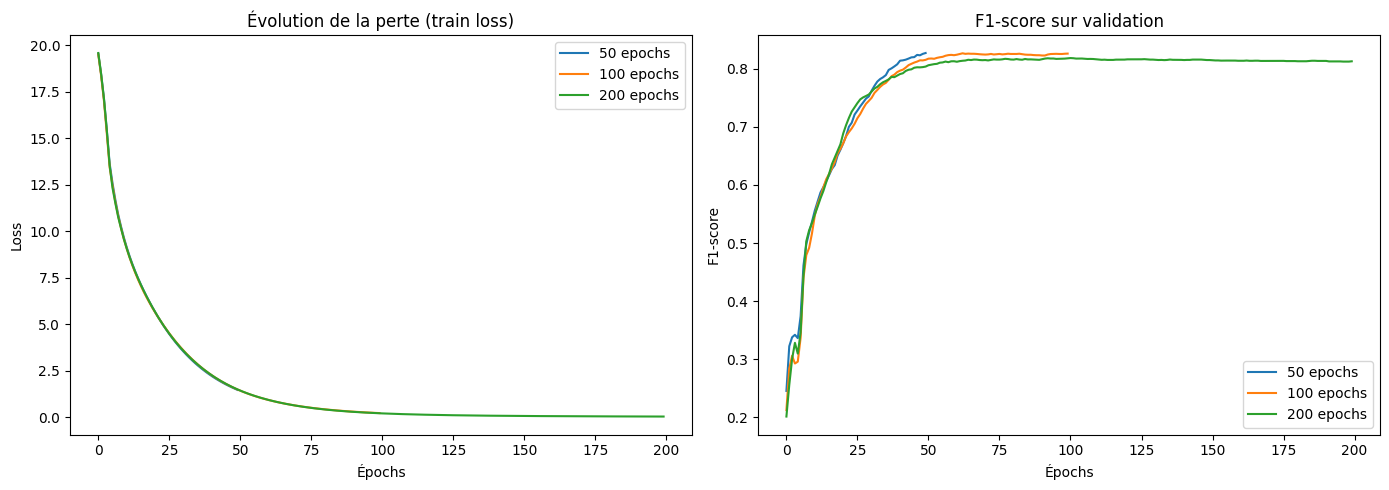


Meilleur nombre d'épochs trouvé : 50

Évaluation sur le test set :
Accuracy : 0.8599
F1-score : 0.8513


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Charger le corpus
df = pd.read_csv("labeledData_fixed.csv")

# Chunking
def chunk_dataset(df, max_len=20):
    words = df['word'].tolist()
    tags = df['tag'].tolist()
    return [(words[i:i+max_len], tags[i:i+max_len]) for i in range(0, len(words), max_len)]

chunks = chunk_dataset(df, max_len=20)
train_val_chunks, test_chunks = train_test_split(chunks, test_size=0.2, random_state=2)
train_chunks, val_chunks = train_test_split(train_val_chunks, test_size=0.15, random_state=2)

# Vocabulaires
all_words = {w for sent in train_chunks for w in sent[0]}
all_tags = {t for sent in train_chunks for t in sent[1]}
word_to_ix = {word: i+1 for i, word in enumerate(sorted(all_words))}
tag_to_ix = {tag: i for i, tag in enumerate(sorted(all_tags))}
ix_to_tag = {v: k for k, v in tag_to_ix.items()}

# Encodage
def encode_chunks(chunks, word_to_ix, tag_to_ix):
    encoded_words, encoded_tags = [], []
    for words, tags in chunks:
        encoded_words.append(torch.tensor([word_to_ix.get(w, 0) for w in words], dtype=torch.long))
        encoded_tags.append(torch.tensor([tag_to_ix.get(t, 0) for t in tags], dtype=torch.long))
    return encoded_words, encoded_tags

def pad_sequences(X, Y, max_len):
    X_pad = torch.zeros(len(X), max_len, dtype=torch.long)
    Y_pad = torch.zeros(len(Y), max_len, dtype=torch.long)
    for i, (x, y) in enumerate(zip(X, Y)):
        end = min(len(x), max_len)
        X_pad[i, :end] = x[:end]
        Y_pad[i, :end] = y[:end]
    return X_pad, Y_pad

MAX_LEN = 20
X_train, Y_train = pad_sequences(*encode_chunks(train_chunks, word_to_ix, tag_to_ix), MAX_LEN)
X_val, Y_val = pad_sequences(*encode_chunks(val_chunks, word_to_ix, tag_to_ix), MAX_LEN)
X_test, Y_test = pad_sequences(*encode_chunks(test_chunks, word_to_ix, tag_to_ix), MAX_LEN)

# BiLSTM model
class POSBiLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super(POSBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

# Entraînements
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(word_to_ix) + 1
tagset_size = len(tag_to_ix)
embedding_dim = 110
hidden_dim = 64
batch_size = 128
learning_rate = 0.001

def batchify(X, Y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], Y[i:i+batch_size]

epochs_list = [50, 100, 200]
results = []
history = {}

for num_epochs in epochs_list:
    model = POSBiLSTM(vocab_size, tagset_size, embedding_dim, hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    X_train_dev, Y_train_dev = X_train.to(device), Y_train.to(device)
    X_val_dev, Y_val_dev = X_val.to(device), Y_val.to(device)

    train_losses = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in batchify(X_train_dev, Y_train_dev, batch_size):
            optimizer.zero_grad()
            output = model(xb)
            loss = loss_function(output.view(-1, tagset_size), yb.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss)

        # Évaluation sur validation à chaque epoch
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_dev).argmax(dim=2).cpu().numpy()
            val_true = Y_val.cpu().numpy()
            _, _, f1, _ = precision_recall_fscore_support(val_true.flatten(), val_preds.flatten(), average='weighted')
            val_f1_scores.append(f1)

    # Résultat final de ce cycle
    acc = accuracy_score(val_true.flatten(), val_preds.flatten())
    results.append({"Epochs": num_epochs, "Accuracy": acc, "F1-score": f1})
    history[num_epochs] = {"loss": train_losses, "f1": val_f1_scores}

# Résultats de la recherche
results_df = pd.DataFrame(results)
display(results_df)

# Courbes de perte et F1-score
plt.figure(figsize=(14, 5))

# Courbe de loss
plt.subplot(1, 2, 1)
for epochs, values in history.items():
    plt.plot(values["loss"], label=f"{epochs} epochs")
plt.title("Évolution de la perte (train loss)")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()

# Courbe de F1-score
plt.subplot(1, 2, 2)
for epochs, values in history.items():
    plt.plot(values["f1"], label=f"{epochs} epochs")
plt.title("F1-score sur validation")
plt.xlabel("Épochs")
plt.ylabel("F1-score")
plt.legend()

plt.tight_layout()
plt.show()

# Sélection du meilleur modèle
best_result = max(results, key=lambda x: x["F1-score"])
best_epochs = best_result["Epochs"]
print(f"\nMeilleur nombre d'épochs trouvé : {best_epochs}")

# Réentraîner sur train + val
X_trainval = torch.cat([X_train, X_val], dim=0)
Y_trainval = torch.cat([Y_train, Y_val], dim=0)

X_trainval_dev = X_trainval.to(device)
Y_trainval_dev = Y_trainval.to(device)
X_test_dev = X_test.to(device)
Y_test_dev = Y_test.to(device)

final_model = POSBiLSTM(vocab_size, tagset_size, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for epoch in range(best_epochs):
    final_model.train()
    for xb, yb in batchify(X_trainval_dev, Y_trainval_dev, batch_size):
        optimizer.zero_grad()
        output = final_model(xb)
        loss = loss_function(output.view(-1, tagset_size), yb.view(-1))
        loss.backward()
        optimizer.step()

# Évaluation sur le test set
final_model.eval()
with torch.no_grad():
    test_preds = final_model(X_test_dev).argmax(dim=2).cpu().numpy()
    test_true = Y_test.cpu().numpy()
    test_acc = accuracy_score(test_true.flatten(), test_preds.flatten())
    _, _, test_f1, _ = precision_recall_fscore_support(test_true.flatten(), test_preds.flatten(), average='weighted')

print("\nÉvaluation sur le test set :")
print(f"Accuracy : {test_acc:.4f}")
print(f"F1-score : {test_f1:.4f}")


### Avec weighting

   Epochs  Accuracy  F1-score
0      50  0.715966  0.729035
1     100  0.728992  0.749886
2     200  0.795798  0.794442


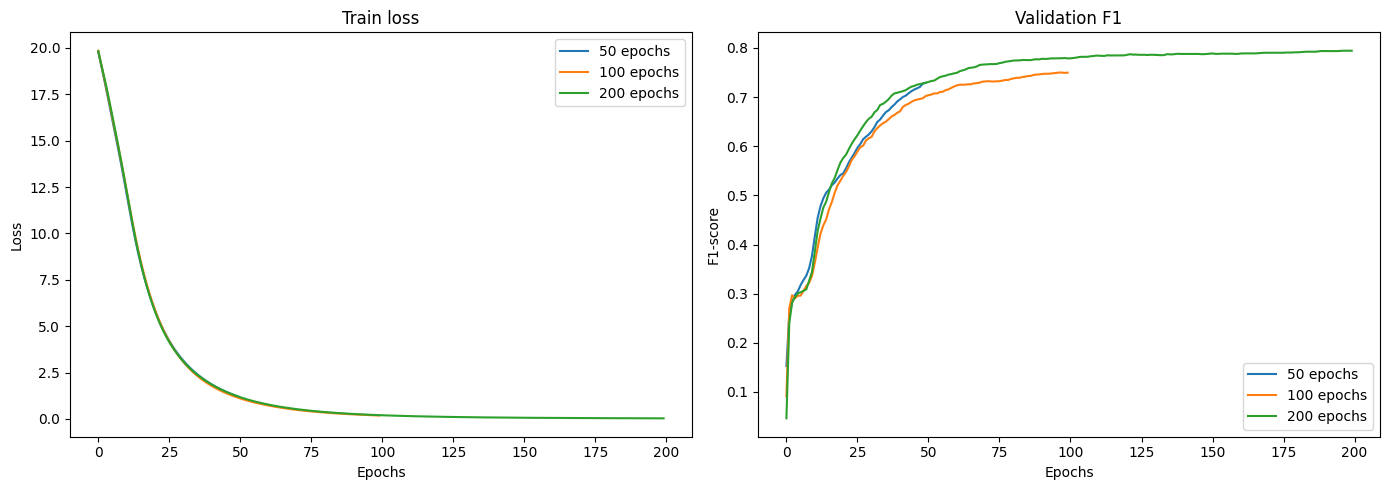


Évaluation finale :
Accuracy: 0.8431

Classification report :
              precision    recall  f1-score   support

         ADJ      0.673     0.660     0.667       103
         ADV      0.631     0.596     0.613       109
           C      0.811     0.778     0.794       176
          DT      0.836     0.821     0.828       223
         FOC      0.545     0.667     0.600        18
          IN      0.200     0.273     0.231        11
         INT      0.714     0.769     0.741        13
         NEG      0.923     0.980     0.950        49
          NN      0.836     0.860     0.848       884
      NNK_PP      1.000     0.706     0.828        17
         NNP      0.726     0.608     0.662        74
         NUM      0.455     0.667     0.541        15
        PDEM      0.375     0.231     0.286        13
          PP      0.925     0.878     0.901        98
        PPOS      0.667     0.444     0.533         9
        PRED      0.250     0.286     0.267         7
        PROR      

In [ ]:
# === BiLSTM avec paramètres fixes + class weighting + classification report + error analysis ===

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import numpy as np
import random

random.seed(23)

# Charger le corpus
df = pd.read_csv("labeledData_fixed.csv")

# Chunking
def chunk_dataset(df, max_len=20):
    words = df['word'].tolist()
    tags = df['tag'].tolist()
    return [(words[i:i+max_len], tags[i:i+max_len]) for i in range(0, len(words), max_len)]

chunks = chunk_dataset(df, max_len=20)
train_val_chunks, test_chunks = train_test_split(chunks, test_size=0.2, random_state=2)
train_chunks, val_chunks = train_test_split(train_val_chunks, test_size=0.15, random_state=2)

# Vocabulaires
all_words = {w for sent in train_chunks for w in sent[0]}
all_tags = {t for sent in train_chunks for t in sent[1]}
word_to_ix = {word: i+1 for i, word in enumerate(sorted(all_words))}
tag_to_ix = {tag: i for i, tag in enumerate(sorted(all_tags))}
ix_to_tag = {v: k for k, v in tag_to_ix.items()}

# Poids de classes
tag_counts = Counter(df['tag'].tolist())
total = sum(tag_counts.values())
class_weights = [total / tag_counts[tag] for tag in tag_to_ix.keys()]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Encodage

def encode_chunks(chunks, word_to_ix, tag_to_ix):
    encoded_words, encoded_tags = [], []
    for words, tags in chunks:
        encoded_words.append(torch.tensor([word_to_ix.get(w, 0) for w in words], dtype=torch.long))
        encoded_tags.append(torch.tensor([tag_to_ix.get(t, 0) for t in tags], dtype=torch.long))
    return encoded_words, encoded_tags

def pad_sequences(X, Y, max_len):
    X_pad = torch.zeros(len(X), max_len, dtype=torch.long)
    Y_pad = torch.full((len(Y), max_len), fill_value=-100, dtype=torch.long)
    for i, (x, y) in enumerate(zip(X, Y)):
        end = min(len(x), max_len)
        X_pad[i, :end] = x[:end]
        Y_pad[i, :end] = y[:end]
    return X_pad, Y_pad

MAX_LEN = 20
X_train, Y_train = pad_sequences(*encode_chunks(train_chunks, word_to_ix, tag_to_ix), MAX_LEN)
X_val, Y_val = pad_sequences(*encode_chunks(val_chunks, word_to_ix, tag_to_ix), MAX_LEN)
X_test, Y_test = pad_sequences(*encode_chunks(test_chunks, word_to_ix, tag_to_ix), MAX_LEN)

# BiLSTM
class POSBiLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super(POSBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        return self.fc(x)

# Paramètres fixes
embedding_dim = 110
hidden_dim = 64
batch_size = 128
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(word_to_ix) + 1
tagset_size = len(tag_to_ix)

# Batchifier
def batchify(X, Y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], Y[i:i+batch_size]

# Grid sur les epochs
epochs_list = [50, 100, 200]
results = []
history = {}

for num_epochs in epochs_list:
    model = POSBiLSTM(vocab_size, tagset_size, embedding_dim, hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights_tensor.to(device))

    X_train_dev, Y_train_dev = X_train.to(device), Y_train.to(device)
    X_val_dev, Y_val_dev = X_val.to(device), Y_val.to(device)

    train_losses = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in batchify(X_train_dev, Y_train_dev, batch_size):
            optimizer.zero_grad()
            output = model(xb)
            loss = loss_function(output.view(-1, tagset_size), yb.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss)

        # F1 sur validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_dev)
            val_preds = val_logits.argmax(dim=2).cpu().numpy()
            val_true = Y_val.cpu().numpy()
            mask = val_true != -100
            true = val_true[mask].flatten()
            pred = val_preds[mask].flatten()
            from sklearn.metrics import f1_score
            f1 = f1_score(true, pred, average='weighted')
            val_f1_scores.append(f1)

    acc = accuracy_score(true, pred)
    results.append({"Epochs": num_epochs, "Accuracy": acc, "F1-score": f1})
    history[num_epochs] = {"loss": train_losses, "f1": val_f1_scores}

# Résultats + courbes
results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
for e, h in history.items():
    plt.plot(h["loss"], label=f"{e} epochs")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for e, h in history.items():
    plt.plot(h["f1"], label=f"{e} epochs")
plt.title("Validation F1")
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.legend()
plt.tight_layout()
plt.show()

# Réentraînement + test
best_epochs = max(results, key=lambda x: x["F1-score"])["Epochs"]
final_model = POSBiLSTM(vocab_size, tagset_size, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights_tensor.to(device))

X_trainval = torch.cat([X_train, X_val], dim=0).to(device)
Y_trainval = torch.cat([Y_train, Y_val], dim=0).to(device)
X_test_dev = X_test.to(device)
Y_test_dev = Y_test.to(device)

for epoch in range(best_epochs):
    final_model.train()
    for xb, yb in batchify(X_trainval, Y_trainval, batch_size):
        optimizer.zero_grad()
        output = final_model(xb)
        loss = loss_function(output.view(-1, tagset_size), yb.view(-1))
        loss.backward()
        optimizer.step()

# Évaluation + report + erreur
final_model.eval()
with torch.no_grad():
    test_logits = final_model(X_test_dev)
    test_preds = test_logits.argmax(dim=2).cpu().view(-1)
    test_labels = Y_test.view(-1)
    mask = test_labels != -100

acc = accuracy_score(test_labels[mask], test_preds[mask])
print("\nÉvaluation finale :")
print(f"Accuracy: {acc:.4f}")

print("\nClassification report :")
print(classification_report(
    [ix_to_tag[i.item()] for i in test_labels[mask]],
    [ix_to_tag[i.item()] for i in test_preds[mask]],
    digits=3
))

# Error analysis sur 2 phrases du test set
print("\nError analysis")
sample_chunks = random.sample(test_chunks, 10)
shown = 0
for words, true_tags in sample_chunks:
    ids = torch.tensor([[word_to_ix.get(w, 0) for w in words]]).to(device)
    with torch.no_grad():
        logits = final_model(ids)
        probs = F.softmax(logits, dim=-1).squeeze(0)
        preds = torch.argmax(probs, dim=-1).cpu().tolist()
        confs = torch.max(probs, dim=-1).values.cpu().tolist()

    pred_tags = [ix_to_tag[i] for i in preds[:len(words)]]
    print("\n--- Phrase ---")
    for w, t, p, c in zip(words, true_tags, pred_tags, confs):
        print(f"{w:<12} | Vrai: {t:<8} | Prédit: {p:<8} | Confiance: {c:.2f}")
    if any(t != p for t, p in zip(true_tags, pred_tags)):
        shown += 1
    if shown >= 2:
        break


## CRF

In [ ]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn_crfsuite import CRF

# Charger les données
df = pd.read_csv("labeledData_fixed.csv")

# Découpage en chunks (phrases simulées de longueur max 20)
MAX_LEN = 20
words = df['word'].tolist()
tags = df['tag'].tolist()
sequences = []
for i in range(0, len(words), MAX_LEN):
    w_chunk = words[i:i + MAX_LEN]
    t_chunk = tags[i:i + MAX_LEN]
    sequences.append(list(zip(w_chunk, t_chunk)))

# Split train/val/test
train_val, test = train_test_split(sequences, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

# Fonction pour extraire les features d’un mot
def word2features(word):
    return {
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit()
    }

# Préparation des données
def prepare(sentences):
    X = [[word2features(w) for w, _ in s] for s in sentences]
    y = [[t for _, t in s] for s in sentences]
    return X, y

X_train, y_train = prepare(train)
X_val, y_val = prepare(val)
X_test, y_test = prepare(test)

# Entraînement CRF
crf = CRF(algorithm='lbfgs', max_iterations=100)
crf.fit(X_train, y_train)

# Évaluation
y_pred = crf.predict(X_test)
flat_true = [t for sent in y_test for t in sent]
flat_pred = [t for sent in y_pred for t in sent]

print("Accuracy:", accuracy_score(flat_true, flat_pred))
print("\nReport :\n", classification_report(flat_true, flat_pred, digits=3))


Accuracy: 0.798984771573604

Report :
               precision    recall  f1-score   support

         ADJ      0.508     0.673     0.579        98
         ADV      0.706     0.270     0.390        89
           C      0.768     0.768     0.768       168
        DATE      0.000     0.000     0.000         2
          DT      0.845     0.763     0.802       228
         FOC      0.500     0.167     0.250        12
          IN      0.000     0.000     0.000        10
         INT      0.727     0.320     0.444        25
         NEG      0.981     0.981     0.981        52
          NN      0.707     0.888     0.787       868
      NNK_PP      0.909     0.345     0.500        29
         NNP      0.806     0.397     0.532        73
         NUM      1.000     1.000     1.000        25
        PDEM      0.000     0.000     0.000         9
          PP      1.000     0.602     0.752        98
        PPOS      1.000     0.273     0.429        11
        PRED      0.000     0.000     0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## BiLSTM + CRF

In [ ]:
# BiLSTM + CRF pipeline complet avec grid search

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import product

# ---------------------------
# Données + Mappings
# ---------------------------
df = pd.read_csv("labeledData_fixed.csv")

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=2)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=2)

word_to_ix = {word: i+1 for i, word in enumerate(set(train_df['word']))}
tag_to_ix = {tag: i for i, tag in enumerate(set(train_df['tag']))}
ix_to_tag = {v: k for k, v in tag_to_ix.items()}

PAD_IDX = 0

# Conversion des données
max_len = 50

def df_to_tensor(df, word_to_ix, tag_to_ix):
    sentences, tags = [], []
    sent, tag_seq = [], []
    for word, tag in zip(df['word'], df['tag']):
        sent.append(word_to_ix.get(word, PAD_IDX))
        tag_seq.append(tag_to_ix.get(tag, PAD_IDX))
        if len(sent) == max_len:
            sentences.append(sent)
            tags.append(tag_seq)
            sent, tag_seq = [], []
    return torch.tensor(sentences), torch.tensor(tags)

X_train, Y_train = df_to_tensor(train_df, word_to_ix, tag_to_ix)
X_val, Y_val = df_to_tensor(val_df, word_to_ix, tag_to_ix)
X_test, Y_test = df_to_tensor(test_df, word_to_ix, tag_to_ix)

# ---------------------------
# CRF Layer
# ---------------------------
class CRF(nn.Module):
    def __init__(self, tagset_size):
        super(CRF, self).__init__()
        self.tagset_size = tagset_size
        self.transitions = nn.Parameter(torch.randn(tagset_size, tagset_size))
        self.start_transitions = nn.Parameter(torch.randn(tagset_size))
        self.end_transitions = nn.Parameter(torch.randn(tagset_size))

    def forward(self, emissions):
        return torch.argmax(emissions, dim=-1)

    def loss(self, emissions, tags):
        emissions = emissions.view(-1, self.tagset_size)
        tags = tags.view(-1)
        return nn.CrossEntropyLoss()(emissions, tags)

# ---------------------------
# BiLSTM + CRF Model
# ---------------------------
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.bilstm(embeds)
        feats = self.fc(lstm_out)
        return self.crf(feats)

    def loss(self, x, y):
        embeds = self.embedding(x)
        lstm_out, _ = self.bilstm(embeds)
        feats = self.fc(lstm_out)
        return self.crf.loss(feats, y)

# ---------------------------
# Grid Search + Entraînement
# ---------------------------
embedding_dims = [100, 200]
hidden_dims = [128, 256]
learning_rates = [0.005, 0.01]
epochs_list = [10, 20]

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(word_to_ix) + 1
tagset_size = len(tag_to_ix)

for emb_dim, hid_dim, lr, epochs in product(embedding_dims, hidden_dims, learning_rates, epochs_list):
    print(f"Testing config: emb={emb_dim}, hid={hid_dim}, lr={lr}, epochs={epochs}")
    model = BiLSTM_CRF(vocab_size, tagset_size, emb_dim, hid_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = model.loss(X_train.to(device), Y_train.to(device))
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_val.to(device)).cpu()
        val_acc = accuracy_score(Y_val.view(-1).numpy(), preds.view(-1).numpy())

    results.append({
        "embedding_dim": emb_dim,
        "hidden_dim": hid_dim,
        "lr": lr,
        "epochs": epochs,
        "val_accuracy": val_acc
    })

# ---------------------------
# Test avec meilleur modèle
# ---------------------------
best_config = max(results, key=lambda x: x["val_accuracy"])
best_emb = best_config["embedding_dim"]
best_hid = best_config["hidden_dim"]
best_lr = best_config["lr"]
best_epochs = best_config["epochs"]

full_train_df = pd.concat([train_df, val_df])
X_full, Y_full = df_to_tensor(full_train_df, word_to_ix, tag_to_ix)

model = BiLSTM_CRF(vocab_size, tagset_size, best_emb, best_hid).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_lr)

for epoch in range(best_epochs):
    model.train()
    optimizer.zero_grad()
    loss = model.loss(X_full.to(device), Y_full.to(device))
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    test_pred = model(X_test.to(device)).cpu()
    test_acc = accuracy_score(Y_test.view(-1).numpy(), test_pred.view(-1).numpy())

print(f"\n✅ Best config: {best_config}")
print(f"🎯 Test Accuracy: {test_acc:.4f}")

Testing config: emb=100, hid=128, lr=0.005, epochs=10
Testing config: emb=100, hid=128, lr=0.005, epochs=20
Testing config: emb=100, hid=128, lr=0.01, epochs=10
Testing config: emb=100, hid=128, lr=0.01, epochs=20
Testing config: emb=100, hid=256, lr=0.005, epochs=10
Testing config: emb=100, hid=256, lr=0.005, epochs=20
Testing config: emb=100, hid=256, lr=0.01, epochs=10
Testing config: emb=100, hid=256, lr=0.01, epochs=20
Testing config: emb=200, hid=128, lr=0.005, epochs=10
Testing config: emb=200, hid=128, lr=0.005, epochs=20
Testing config: emb=200, hid=128, lr=0.01, epochs=10
Testing config: emb=200, hid=128, lr=0.01, epochs=20
Testing config: emb=200, hid=256, lr=0.005, epochs=10
Testing config: emb=200, hid=256, lr=0.005, epochs=20
Testing config: emb=200, hid=256, lr=0.01, epochs=10
Testing config: emb=200, hid=256, lr=0.01, epochs=20

✅ Best config: {'embedding_dim': 200, 'hidden_dim': 256, 'lr': 0.01, 'epochs': 20, 'val_accuracy': 0.786984126984127}
🎯 Test Accuracy: 0.7864


### Avec weighting à abandonner je crois


📊 Classification Report:
              precision    recall  f1-score   support

         ADJ      0.683     0.705     0.694       122
         ADV      0.676     0.591     0.630       127
           C      0.802     0.765     0.783       170
          DT      0.808     0.790     0.799       219
         FOC      0.737     0.560     0.636        25
          IN      0.857     0.500     0.632        12
         INT      0.632     0.600     0.615        20
         NEG      1.000     0.943     0.971        35
          NN      0.781     0.780     0.780       817
      NNK_PP      0.900     0.643     0.750        28
         NNP      0.682     0.706     0.694        85
         NUM      0.875     0.438     0.583        16
        PDEM      0.400     0.500     0.444         8
          PP      0.870     0.897     0.883        97
        PPOS      0.909     0.625     0.741        16
        PRED      0.833     0.714     0.769         7
        PROR      0.735     0.781     0.758        64
 

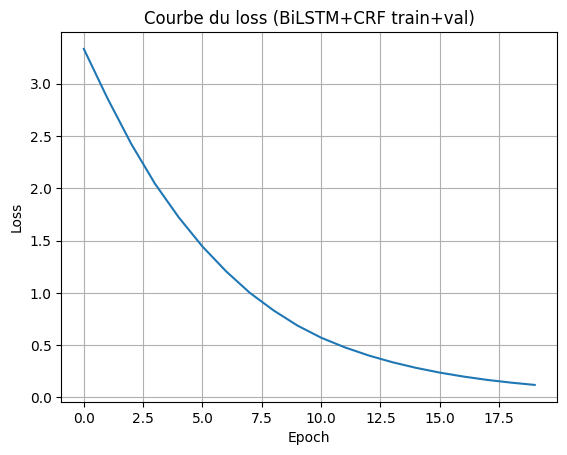


🧪 Error analysis : prédictions sur 2 phrases du test set


TypeError: 'int' object is not subscriptable

In [ ]:
# === BiLSTM + CRF pondéré + classification_report + error analysis ===

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from itertools import product
from collections import Counter
import numpy as np
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

random.seed(42)

# === Chargement et chunking identique aux autres modèles ===
df = pd.read_csv("labeledData_fixed.csv")

MAX_LEN = 50

def chunk_dataset(df, max_len=50):
    words = df["word"].tolist()
    tags = df["tag"].tolist()
    return [(words[i:i + max_len], tags[i:i + max_len]) for i in range(0, len(words), max_len) if len(words[i:i + max_len]) == max_len]

chunks = chunk_dataset(df, MAX_LEN)
train_val_chunks, test_chunks = train_test_split(chunks, test_size=0.2, random_state=42)
train_chunks, val_chunks = train_test_split(train_val_chunks, test_size=0.2, random_state=42)

# === Vocab et tagset ===
word_to_ix = {word: i + 1 for i, word in enumerate({w for s in train_chunks for w in s[0]})}
tag_to_ix = {tag: i for i, tag in enumerate({t for s in train_chunks for t in s[1]})}
ix_to_tag = {i: t for t, i in tag_to_ix.items()}
ix_to_word = {i: w for w, i in word_to_ix.items()}
PAD_IDX = 0

# === Pondération des classes ===
flat_tags = [t for s in train_chunks for t in s[1]]
tag_counts = Counter(flat_tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag_to_ix], dtype=torch.float)

# === Conversion tensorielle ===
def chunks_to_tensor(chunks, word_to_ix, tag_to_ix):
    X, Y = [], []
    for words, tags in chunks:
        word_ids = [word_to_ix.get(w, PAD_IDX) for w in words]
        tag_ids = [tag_to_ix.get(t, PAD_IDX) for t in tags]
        if len(word_ids) == MAX_LEN:
            X.append(word_ids)
            Y.append(tag_ids)
    return torch.tensor(X), torch.tensor(Y)

X_train, Y_train = chunks_to_tensor(train_chunks, word_to_ix, tag_to_ix)
X_val, Y_val = chunks_to_tensor(val_chunks, word_to_ix, tag_to_ix)
X_test, Y_test = chunks_to_tensor(test_chunks, word_to_ix, tag_to_ix)

# === CRF ===
class CRF(nn.Module):
    def __init__(self, tagset_size, class_weights):
        super().__init__()
        self.tagset_size = tagset_size
        self.transitions = nn.Parameter(torch.randn(tagset_size, tagset_size))
        self.start_transitions = nn.Parameter(torch.randn(tagset_size))
        self.end_transitions = nn.Parameter(torch.randn(tagset_size))
        self.class_weights = class_weights

    def forward(self, emissions):
        return torch.argmax(emissions, dim=-1)

    def loss(self, emissions, tags):
        emissions = emissions.view(-1, self.tagset_size)
        tags = tags.view(-1)
        return nn.CrossEntropyLoss(weight=self.class_weights, ignore_index=-100)(emissions, tags)

# === BiLSTM + CRF ===
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, class_weights):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, class_weights)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.bilstm(embeds)
        feats = self.fc(lstm_out)
        return self.crf(feats)

    def loss(self, x, y):
        embeds = self.embedding(x)
        lstm_out, _ = self.bilstm(embeds)
        feats = self.fc(lstm_out)
        return self.crf.loss(feats, y)

# === Grid Search + entraînement ===
embedding_dims = [100, 200]
hidden_dims = [128, 256]
learning_rates = [0.005, 0.01]
epochs_list = [10, 20]

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(word_to_ix) + 1
tagset_size = len(tag_to_ix)
class_weights = class_weights.to(device)

for emb_dim, hid_dim, lr, epochs in product(embedding_dims, hidden_dims, learning_rates, epochs_list):
    model = BiLSTM_CRF(vocab_size, tagset_size, emb_dim, hid_dim, class_weights).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = model.loss(X_train.to(device), Y_train.to(device))
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        preds = model(X_val.to(device)).cpu()
        val_acc = accuracy_score(Y_val.view(-1).numpy(), preds.view(-1).numpy())
    results.append({"embedding_dim": emb_dim, "hidden_dim": hid_dim, "lr": lr, "epochs": epochs, "val_accuracy": val_acc})

# === Meilleur modèle ===
best = max(results, key=lambda x: x["val_accuracy"])
best_emb = best["embedding_dim"]
best_hid = best["hidden_dim"]
best_lr = best["lr"]
best_epochs = best["epochs"]

X_full, Y_full = chunks_to_tensor(train_chunks + val_chunks, word_to_ix, tag_to_ix)
model = BiLSTM_CRF(vocab_size, tagset_size, best_emb, best_hid, class_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_lr)

losses = []
for _ in range(best_epochs):
    model.train()
    optimizer.zero_grad()
    loss = model.loss(X_full.to(device), Y_full.to(device))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# === Évaluation + Report ===
model.eval()
with torch.no_grad():
    test_pred = model(X_test.to(device)).cpu().numpy()
    test_true = Y_test.numpy()
    mask = test_true != -100
    flat_true = test_true[mask]
    flat_pred = test_pred[mask]
    print("\n📊 Classification Report:")
    print(classification_report([ix_to_tag[t] for t in flat_true], [ix_to_tag[p] for p in flat_pred], digits=3))

# === Courbe du loss ===
plt.plot(losses)
plt.title("Courbe du loss (BiLSTM+CRF train+val)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# === Error analysis sur 2 phrases du test set ===
print("\n🧪 Error analysis : prédictions sur 2 phrases du test set")
random.seed(23)
sample_chunks = random.sample(test_chunks, 10)
shown = 0
for words, true_tags in sample_chunks:
    word_ids = torch.tensor([[word_to_ix.get(w, 0) for w in words]]).to(device)
    with torch.no_grad():
        logits = model(word_ids)
        probs = logits.float()
        preds = torch.argmax(probs, dim=-1).cpu().tolist()[0]
        confs = torch.max(F.softmax(probs, dim=-1), dim=-1).values.cpu().tolist()[0]

    pred_tags = [ix_to_tag[p] for p in preds[:len(words)]]
    errors = [(w, t, p) for w, t, p in zip(words, true_tags, pred_tags) if t != p]

    print("\n--- Phrase ---")
    for w, t, p, c in zip(words, true_tags, pred_tags, confs):
        print(f"{w:<12} | Vrai: {t:<8} | Prédit: {p:<8} | Confiance: {c:.2f}")

    if errors:
        shown += 1
    if shown >= 2:
        break


# Transfert Learning

### Dictionnaire de mapping vers UD tagset (à utiliser pour comparer les performances du modèle, souci de cohérence)

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split

# === Paramètres ===
MAX_LEN = 20
UD_MAPPING = True  # ⬅️ mettre False pour désactiver le mapping vers UD

# === Fonction de mapping vers UD ===
def map_to_ud(tag, token):
    """
    Mappe un tag POS amazigh du dataset original de Outahajala vers un tag Universal Dependencies (UD).
    Gère aussi la classe "DATE" dynamiquement si le token est un chiffre.
    """
    tag_map_to_ud = {
        "NN": "NOUN", "NNP": "PROPN", "VB": "VERB", "VBP": "VERB",
        "PP": "PRON", "PRPR": "PRON", "PROR": "PRON", "PPOS": "PRON", "PROT": "PRON",
        "DT": "DET", "PDEM": "DET",
        "FOC": "PART", "NEG": "PART", "PRED": "PART",
        "S": "ADP", "S_PP": "ADP", "IN": "ADP", "NNK_PP": "NOUN",
        "C": "CCONJ", "REL": "PRON", "ADV": "ADV", "ADJ": "ADJ",
        "NUM": "NUM", "INT": "INTJ", "VOC": "INTJ",
        "ROT": "X", "PUNC": "PUNCT"
    }

    if tag == "DATE":
        return "NUM" if token.isdigit() or re.fullmatch(r"\d{4}", token) else "NOUN"

    return tag_map_to_ud.get(tag, "X")

# === Chargement du corpus ===
df = pd.read_csv("labeledData_fixed.csv")

if UD_MAPPING:
    df["orig_tag"] = df["tag"]
    df["tag"] = [map_to_ud(t, w) for t, w in zip(df["tag"], df["word"])]

# === Chunking en séquences de longueur max 20 ===
def chunk_dataset(df, max_len):
    words = df['word'].tolist()
    tags = df['tag'].tolist()
    return [(words[i:i+max_len], tags[i:i+max_len]) for i in range(0, len(words), max_len)]

chunks = chunk_dataset(df, MAX_LEN)

# === Splits train / val / test fixes ===
train_data, test_data = train_test_split(chunks, test_size=0.2, random_state=23)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=23)

# === Mappings tag2id et id2tag cohérents sur tout le corpus ===
tag_list = sorted({tag for _, tags in chunks for tag in tags})
tag2id = {tag: i for i, tag in enumerate(tag_list)}
id2tag = {i: tag for tag, i in tag2id.items()}
num_labels = len(tag2id)


### Début

In [ ]:
!git clone https://github.com/qanastek/ANTILLES.git

Cloning into 'ANTILLES'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 80 (delta 26), reused 15 (delta 8), pack-reused 17 (from 1)
Receiving objects: 100% (80/80), 4.97 MiB | 7.55 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
import os

os.listdir("ANTILLES/ANTILLES")

['test.conllu', 'train.conllu', 'dev.conllu']

In [ ]:
def load_conllu(file_path):
    sentences = []
    pos_tags = []
    with open(file_path, encoding='utf-8') as f:
        tokens = []
        tags = []
        for line in f:
            line = line.strip()
            if line == "":
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens = []
                    tags = []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])  # UPOS
    return sentences, pos_tags

fr_sentences, fr_tags = load_conllu("ANTILLES/ANTILLES/train.conllu")


## Fine-tuning direct de CamemBERT sur le dataset amazigh



### Installations

In [ ]:
!pip install -U transformers

  Using cached transformers-4.53.0-py3-none-any.whl.metadata (39 kB)
Using cached transformers-4.53.0-py3-none-any.whl (10.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3


In [ ]:
from transformers import TrainingArguments
print(TrainingArguments)

<class 'transformers.training_args.TrainingArguments'>


### Starts here without weighting

#### Sans UD mapping

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-14-467142682.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


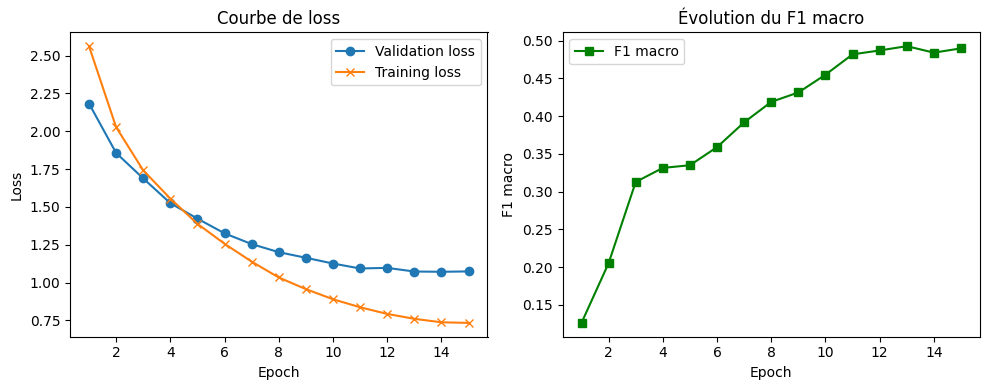


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VB       | 0.48       | ['▁i', 'ṛẓ', 'mn']
imi          | NN       | NN       | 0.81       | ['▁', 'imi']
!            | PUNC     | PUNC     | 0.82       | ['▁!']
ha           | DT       | S        | 0.42       | ['▁ha']
wnni         | PDEM     | VB       | 0.69       | ['▁w', 'nni']
iṛẓmn        | VBP      | VB       | 0.44       | ['▁i', 'ṛẓ', 'mn']
tiṭṭawin     | NN       | NN       | 0.78       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNC     | PUNC     | 0.82       | ['▁!']
acku         | C        | C        | 0.51       | ['▁ac', 'ku']
ur           | NEG      | NEG      | 0.48       | ['▁', 'ur']
jjin         | ADV      | ADV      | 0.21       | ['▁j', 'jin']
ẓṛin         | VB       | ADV      | 0.18       | ['▁', 'ẓṛ', 'in']
am          

In [ ]:
# === Fine-tuning direct de CamemBERT sans pondération, sans UD mapping, avec courbes et error analysis ===

import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
from transformers import (
    CamembertTokenizerFast, CamembertForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Tokenizer et dataset ===
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle (sans weighting) ===
model = CamembertForTokenClassification.from_pretrained(
    "camembert-base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === TrainingArguments ===
args = TrainingArguments(
    output_dir="./camembert-pos-noweight",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

trainer.save_model("./camembert-pos-noweight")

# === Error analysis : phrase longue (2× MAX_LEN) ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")

random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    has_error = False

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)

    if has_error:
        break


#### Avec UD mapping

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-11-467142682.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


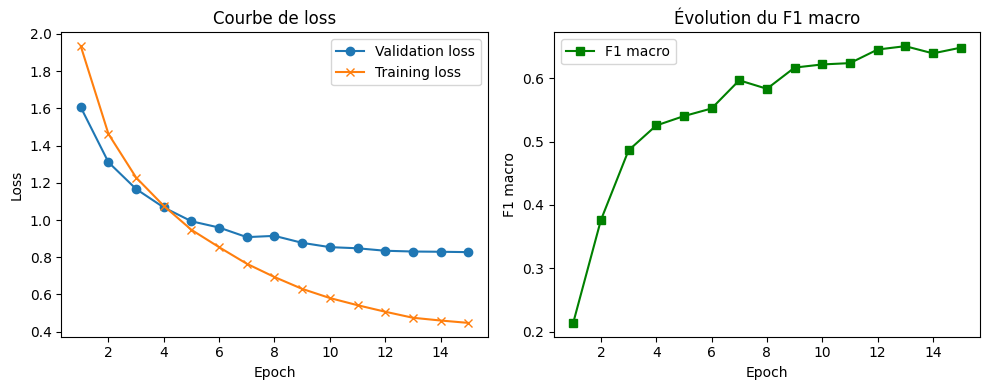


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 0.83       | ['▁i', 'ṛẓ', 'mn']
imi          | NOUN     | NOUN     | 0.86       | ['▁', 'imi']
!            | PUNCT    | PUNCT    | 0.87       | ['▁!']
ha           | DET      | PRON     | 0.77       | ['▁ha']
wnni         | DET      | VERB     | 0.83       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 0.83       | ['▁i', 'ṛẓ', 'mn']
tiṭṭawin     | NOUN     | NOUN     | 0.86       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 0.87       | ['▁!']
acku         | CCONJ    | CCONJ    | 0.59       | ['▁ac', 'ku']
ur           | PART     | PART     | 0.59       | ['▁', 'ur']
jjin         | ADV      | ADV      | 0.25       | ['▁j', 'jin']
ẓṛin         | VERB     | ADV      | 0.23       | ['▁', 'ẓṛ', 'in']
am          

In [ ]:
# === Fine-tuning direct de CamemBERT sans pondération, sans UD mapping, avec courbes et error analysis ===

import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
from transformers import (
    CamembertTokenizerFast, CamembertForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Tokenizer et dataset ===
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle (sans weighting) ===
model = CamembertForTokenClassification.from_pretrained(
    "camembert-base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === TrainingArguments ===
args = TrainingArguments(
    output_dir="./camembert-pos-noweight",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

trainer.save_model("./camembert-pos-noweight")

# === Error analysis : phrase longue (2× MAX_LEN) ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")

random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    has_error = False

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)

    if has_error:
        break


### Avec le weighting

#### Sans UD mapping

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-729986269.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Train

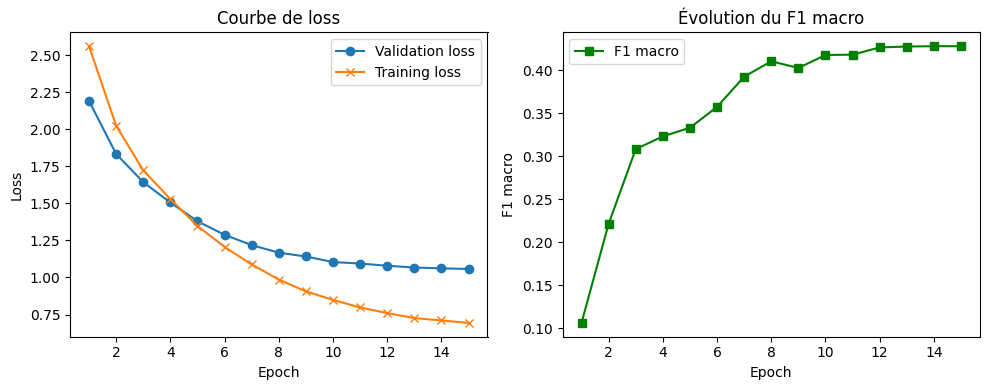


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VB       | 0.55       | ['▁i', 'ṛẓ', 'mn']
imi          | NN       | NN       | 0.82       | ['▁', 'imi']
!            | PUNC     | PUNC     | 0.83       | ['▁!']
ha           | DT       | DT       | 0.23       | ['▁ha']
wnni         | PDEM     | ADV      | 0.22       | ['▁w', 'nni']
iṛẓmn        | VBP      | VB       | 0.23       | ['▁i', 'ṛẓ', 'mn']
tiṭṭawin     | NN       | NN       | 0.70       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNC     | PUNC     | 0.83       | ['▁!']
acku         | C        | C        | 0.43       | ['▁ac', 'ku']
ur           | NEG      | NEG      | 0.49       | ['▁', 'ur']
jjin         | ADV      | VB       | 0.50       | ['▁j', 'jin']
ẓṛin         | VB       | VB       | 0.78       | ['▁', 'ẓṛ', 'in']
am          

In [ ]:
# === Fine-tuning direct de CamemBERT avec pondération, sans UD mapping et courbes ===

import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
from transformers import (
    CamembertTokenizerFast, CamembertForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Pondération inverse de fréquence ===
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# === Tokenizer et dataset ===
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle avec pondération des classes ===
model = CamembertForTokenClassification.from_pretrained("camembert-base", num_labels=num_labels)

# Injecter la méthode compute_loss pour appliquer les class_weights
from torch.nn import CrossEntropyLoss

def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model.compute_loss = compute_loss_with_weights

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === TrainingArguments ===
args = TrainingArguments(
    output_dir="./camembert-pos-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

trainer.save_model("./camembert-pos-weighted")

# === Error analysis : phrase longue (2× MAX_LEN) ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")

random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-12-729986269.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


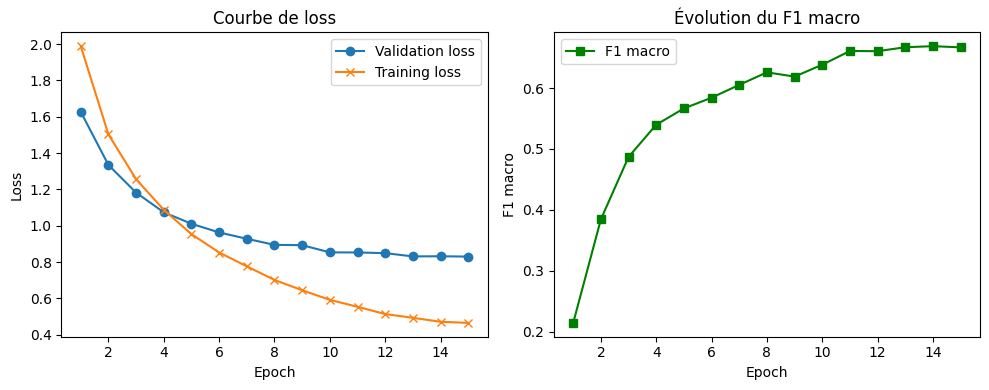


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 0.81       | ['▁i', 'ṛẓ', 'mn']
imi          | NOUN     | NOUN     | 0.86       | ['▁', 'imi']
!            | PUNCT    | PUNCT    | 0.86       | ['▁!']
ha           | DET      | PRON     | 0.69       | ['▁ha']
wnni         | DET      | VERB     | 0.84       | ['▁w', 'nni']
iṛẓmn        | VERB     | NOUN     | 0.27       | ['▁i', 'ṛẓ', 'mn']
tiṭṭawin     | NOUN     | NOUN     | 0.82       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 0.86       | ['▁!']
acku         | CCONJ    | DET      | 0.33       | ['▁ac', 'ku']
ur           | PART     | PART     | 0.60       | ['▁', 'ur']
jjin         | ADV      | VERB     | 0.51       | ['▁j', 'jin']
ẓṛin         | VERB     | VERB     | 0.81       | ['▁', 'ẓṛ', 'in']
am          

In [ ]:
# === Fine-tuning direct de CamemBERT avec pondération, sans UD mapping et courbes ===

import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
from transformers import (
    CamembertTokenizerFast, CamembertForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Pondération inverse de fréquence ===
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# === Tokenizer et dataset ===
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle avec pondération des classes ===
model = CamembertForTokenClassification.from_pretrained("camembert-base", num_labels=num_labels)

# Injecter la méthode compute_loss pour appliquer les class_weights
from torch.nn import CrossEntropyLoss

def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model.compute_loss = compute_loss_with_weights

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === TrainingArguments ===
args = TrainingArguments(
    output_dir="./camembert-pos-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

trainer.save_model("./camembert-pos-weighted")

# === Error analysis : phrase longue (2× MAX_LEN) ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")

random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


## Pré-fine-tuning sur un dataset français + re-fine-tuning sur le dataset amazigh

### Sans weighting

#### Sans UD mapping

Map:   0%|          | 0/14449 [00:00<?, ? examples/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-2740575975.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-2740575975.py:150: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


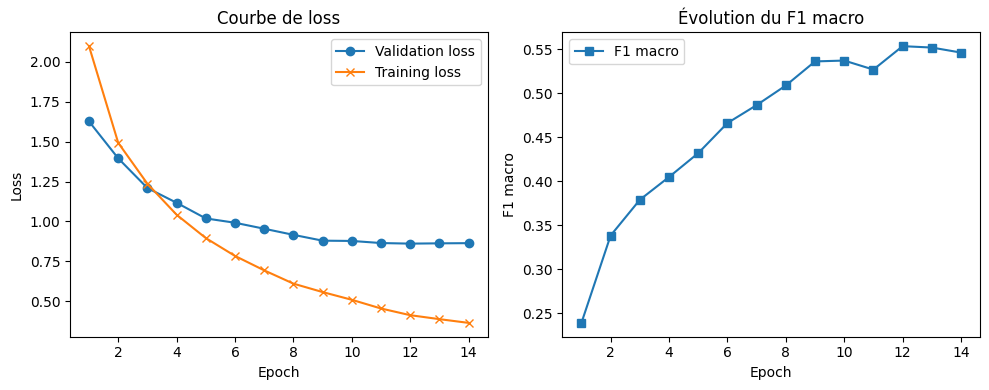


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VBP      | 0.54       | ['▁i', 'ṛẓ', 'mn']
imi          | NN       | NN       | 0.93       | ['▁', 'imi']
!            | PUNC     | PUNC     | 0.94       | ['▁!']
ha           | DT       | DT       | 0.51       | ['▁ha']
wnni         | PDEM     | PDEM     | 0.27       | ['▁w', 'nni']
iṛẓmn        | VBP      | VBP      | 0.58       | ['▁i', 'ṛẓ', 'mn']
tiṭṭawin     | NN       | NN       | 0.93       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNC     | PUNC     | 0.94       | ['▁!']
acku         | C        | C        | 0.84       | ['▁ac', 'ku']
ur           | NEG      | NEG      | 0.82       | ['▁', 'ur']
jjin         | ADV      | VB       | 0.87       | ['▁j', 'jin']
ẓṛin         | VB       | VB       | 0.88       | ['▁', 'ẓṛ', 'in']

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import CamembertTokenizerFast, CamembertForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random

# === Chargement tokenizer CamemBERT ===
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")


# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None

        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id

        labels.append(label)
    tokenized["labels"] = labels
    return tokenized


# === PRÉ-FINE-TUNING CamemBERT sur corpus ANTILLES ===

def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

fr_sentences, fr_tags = load_conllu("ANTILLES/ANTILLES/train.conllu")
unique_tags_fr = sorted(set(tag for seq in fr_tags for tag in seq))
tag2id_fr = {tag: i for i, tag in enumerate(unique_tags_fr)}
id2tag_fr = {i: tag for tag, i in tag2id_fr.items()}

examples_fr = [{"tokens": s, "tags": t} for s, t in zip(fr_sentences, fr_tags)]
dataset_fr = Dataset.from_list(examples_fr)
dataset_fr = dataset_fr.rename_columns({"tokens": "words"})
dataset_fr = dataset_fr.map(lambda x: encode_batch(x, tag2id_fr), batched=True)
dataset_fr = dataset_fr.train_test_split(test_size=0.1, seed=42)

model_fr = CamembertForTokenClassification.from_pretrained("camembert-base", num_labels=len(tag2id_fr))

args_fr = TrainingArguments(
    output_dir="./camembert-antilles",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_fr = Trainer(
    model=model_fr,
    args=args_fr,
    train_dataset=dataset_fr["train"],
    eval_dataset=dataset_fr["test"],
    tokenizer=tokenizer
)

trainer_fr.train()
trainer_fr.save_model("./camembert-antilles")


# === RE-FINE-TUNING CamemBERT sur corpus AMAZIGH ===

examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Charger modèle Antilles et préparer modèle Amazigh
model_fr_loaded = CamembertForTokenClassification.from_pretrained("./camembert-antilles")
model_am = CamembertForTokenClassification.from_pretrained("camembert-base", num_labels=num_labels, id2label=id2tag, label2id=tag2id)
model_am.roberta.load_state_dict(model_fr_loaded.roberta.state_dict())


def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }


args_am = TrainingArguments(
    output_dir="./camembert-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./camembert-amazigh-refinetuned")


# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()


# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)

#### Avec UD mapping

Map:   0%|          | 0/14449 [00:00<?, ? examples/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-13-2740575975.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-13-2740575975.py:150: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


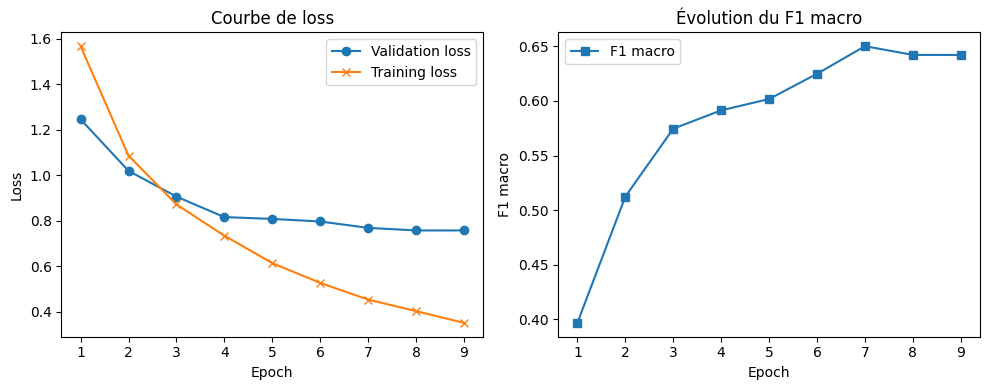


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 0.91       | ['▁i', 'ṛẓ', 'mn']
imi          | NOUN     | NOUN     | 0.92       | ['▁', 'imi']
!            | PUNCT    | PUNCT    | 0.93       | ['▁!']
ha           | DET      | ADP      | 0.88       | ['▁ha']
wnni         | DET      | DET      | 0.72       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 0.91       | ['▁i', 'ṛẓ', 'mn']
tiṭṭawin     | NOUN     | NOUN     | 0.92       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 0.93       | ['▁!']
acku         | CCONJ    | CCONJ    | 0.73       | ['▁ac', 'ku']
ur           | PART     | PART     | 0.79       | ['▁', 'ur']
jjin         | ADV      | VERB     | 0.79       | ['▁j', 'jin']
ẓṛin         | VERB     | ADP      | 0.86       | ['▁', 'ẓṛ', 'in']

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import CamembertTokenizerFast, CamembertForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random

# === Chargement tokenizer CamemBERT ===
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")


# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None

        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id

        labels.append(label)
    tokenized["labels"] = labels
    return tokenized


# === PRÉ-FINE-TUNING CamemBERT sur corpus ANTILLES ===

def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

fr_sentences, fr_tags = load_conllu("ANTILLES/ANTILLES/train.conllu")
unique_tags_fr = sorted(set(tag for seq in fr_tags for tag in seq))
tag2id_fr = {tag: i for i, tag in enumerate(unique_tags_fr)}
id2tag_fr = {i: tag for tag, i in tag2id_fr.items()}

examples_fr = [{"tokens": s, "tags": t} for s, t in zip(fr_sentences, fr_tags)]
dataset_fr = Dataset.from_list(examples_fr)
dataset_fr = dataset_fr.rename_columns({"tokens": "words"})
dataset_fr = dataset_fr.map(lambda x: encode_batch(x, tag2id_fr), batched=True)
dataset_fr = dataset_fr.train_test_split(test_size=0.1, seed=42)

model_fr = CamembertForTokenClassification.from_pretrained("camembert-base", num_labels=len(tag2id_fr))

args_fr = TrainingArguments(
    output_dir="./camembert-antilles",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_fr = Trainer(
    model=model_fr,
    args=args_fr,
    train_dataset=dataset_fr["train"],
    eval_dataset=dataset_fr["test"],
    tokenizer=tokenizer
)

trainer_fr.train()
trainer_fr.save_model("./camembert-antilles")


# === RE-FINE-TUNING CamemBERT sur corpus AMAZIGH ===

examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Charger modèle Antilles et préparer modèle Amazigh
model_fr_loaded = CamembertForTokenClassification.from_pretrained("./camembert-antilles")
model_am = CamembertForTokenClassification.from_pretrained("camembert-base", num_labels=num_labels, id2label=id2tag, label2id=tag2id)
model_am.roberta.load_state_dict(model_fr_loaded.roberta.state_dict())


def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }


args_am = TrainingArguments(
    output_dir="./camembert-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./camembert-amazigh-refinetuned")


# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()


# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)

### Avec weighting

#### Sans UD mapping

Map:   0%|          | 0/14449 [00:00<?, ? examples/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-2075237172.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-2075237172.py:167: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


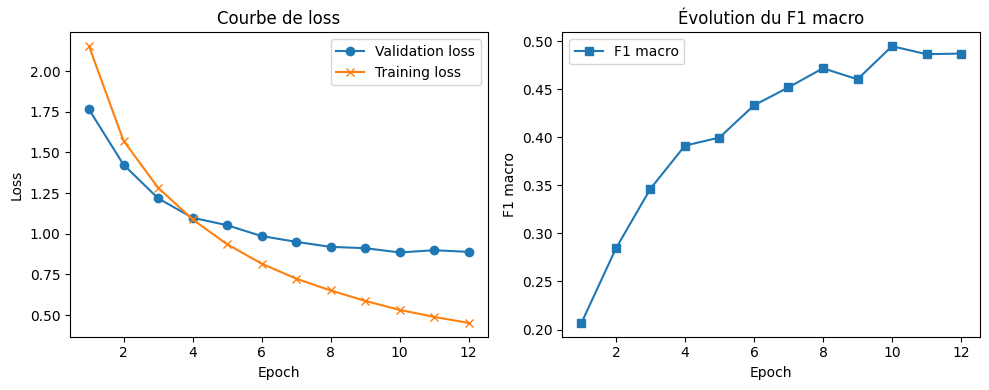


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VBP      | 0.36       | ['▁i', 'ṛẓ', 'mn']
imi          | NN       | NN       | 0.91       | ['▁', 'imi']
!            | PUNC     | PUNC     | 0.93       | ['▁!']
ha           | DT       | DT       | 0.58       | ['▁ha']
wnni         | PDEM     | ADV      | 0.36       | ['▁w', 'nni']
iṛẓmn        | VBP      | NN       | 0.87       | ['▁i', 'ṛẓ', 'mn']
tiṭṭawin     | NN       | NN       | 0.89       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNC     | PUNC     | 0.93       | ['▁!']
acku         | C        | C        | 0.78       | ['▁ac', 'ku']
ur           | NEG      | NEG      | 0.76       | ['▁', 'ur']
jjin         | ADV      | ADV      | 0.50       | ['▁j', 'jin']
ẓṛin         | VB       | ADV      | 0.32       | ['▁', 'ẓṛ', 'in']

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import CamembertTokenizerFast, CamembertForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from collections import Counter

# === Chargement tokenizer CamemBERT ===
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []
    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === PRÉ-FINE-TUNING CamemBERT sur corpus ANTILLES ===
def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

fr_sentences, fr_tags = load_conllu("ANTILLES/ANTILLES/train.conllu")
unique_tags_fr = sorted(set(tag for seq in fr_tags for tag in seq))
tag2id_fr = {tag: i for i, tag in enumerate(unique_tags_fr)}
id2tag_fr = {i: tag for tag, i in tag2id_fr.items()}

examples_fr = [{"tokens": s, "tags": t} for s, t in zip(fr_sentences, fr_tags)]
dataset_fr = Dataset.from_list(examples_fr)
dataset_fr = dataset_fr.rename_columns({"tokens": "words"})
dataset_fr = dataset_fr.map(lambda x: encode_batch(x, tag2id_fr), batched=True)
dataset_fr = dataset_fr.train_test_split(test_size=0.1, seed=42)

model_fr = CamembertForTokenClassification.from_pretrained("camembert-base", num_labels=len(tag2id_fr))

args_fr = TrainingArguments(
    output_dir="./camembert-antilles",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_fr = Trainer(
    model=model_fr,
    args=args_fr,
    train_dataset=dataset_fr["train"],
    eval_dataset=dataset_fr["test"],
    tokenizer=tokenizer
)

trainer_fr.train()
trainer_fr.save_model("./camembert-antilles")

# === RE-FINE-TUNING CamemBERT sur corpus AMAZIGH ===

# Construction du dataset HuggingFace
examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Calcul des poids de classes sur le corpus Amazigh
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# Charger le modèle Antilles et créer le modèle Amazigh
model_fr_loaded = CamembertForTokenClassification.from_pretrained("./camembert-antilles")
model_am = CamembertForTokenClassification.from_pretrained(
    "camembert-base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)
model_am.roberta.load_state_dict(model_fr_loaded.roberta.state_dict())  # Transfert des poids roberta

# Injecter une fonction de perte personnalisée avec pondération
from torch.nn import CrossEntropyLoss

def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model_am.compute_loss = compute_loss_with_weights

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

args_am = TrainingArguments(
    output_dir="./camembert-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./camembert-amazigh-refinetuned")

# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

Map:   0%|          | 0/14449 [00:00<?, ? examples/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-14-2075237172.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-14-2075237172.py:167: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


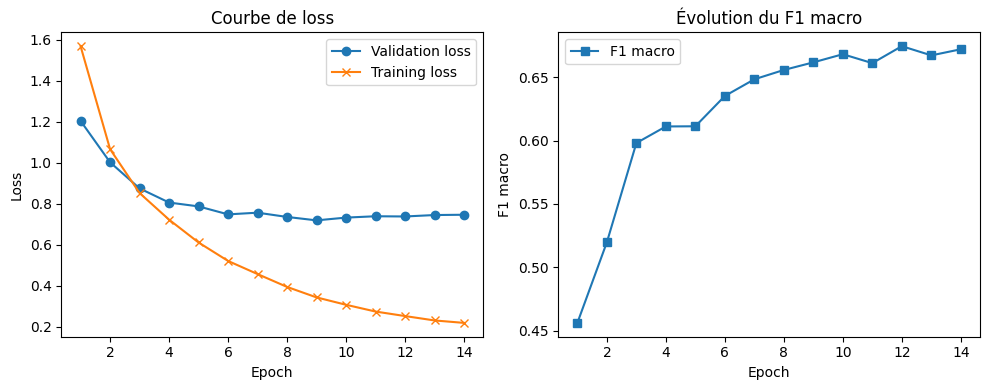


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 0.95       | ['▁i', 'ṛẓ', 'mn']
imi          | NOUN     | NOUN     | 0.96       | ['▁', 'imi']
!            | PUNCT    | PUNCT    | 0.96       | ['▁!']
ha           | DET      | DET      | 0.88       | ['▁ha']
wnni         | DET      | DET      | 0.89       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 0.96       | ['▁i', 'ṛẓ', 'mn']
tiṭṭawin     | NOUN     | NOUN     | 0.96       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 0.96       | ['▁!']
acku         | CCONJ    | PRON     | 0.59       | ['▁ac', 'ku']
ur           | PART     | PART     | 0.87       | ['▁', 'ur']
jjin         | ADV      | VERB     | 0.57       | ['▁j', 'jin']
ẓṛin         | VERB     | VERB     | 0.49       | ['▁', 'ẓṛ', 'in']

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import CamembertTokenizerFast, CamembertForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from collections import Counter

# === Chargement tokenizer CamemBERT ===
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []
    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === PRÉ-FINE-TUNING CamemBERT sur corpus ANTILLES ===
def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

fr_sentences, fr_tags = load_conllu("ANTILLES/ANTILLES/train.conllu")
unique_tags_fr = sorted(set(tag for seq in fr_tags for tag in seq))
tag2id_fr = {tag: i for i, tag in enumerate(unique_tags_fr)}
id2tag_fr = {i: tag for tag, i in tag2id_fr.items()}

examples_fr = [{"tokens": s, "tags": t} for s, t in zip(fr_sentences, fr_tags)]
dataset_fr = Dataset.from_list(examples_fr)
dataset_fr = dataset_fr.rename_columns({"tokens": "words"})
dataset_fr = dataset_fr.map(lambda x: encode_batch(x, tag2id_fr), batched=True)
dataset_fr = dataset_fr.train_test_split(test_size=0.1, seed=42)

model_fr = CamembertForTokenClassification.from_pretrained("camembert-base", num_labels=len(tag2id_fr))

args_fr = TrainingArguments(
    output_dir="./camembert-antilles",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_fr = Trainer(
    model=model_fr,
    args=args_fr,
    train_dataset=dataset_fr["train"],
    eval_dataset=dataset_fr["test"],
    tokenizer=tokenizer
)

trainer_fr.train()
trainer_fr.save_model("./camembert-antilles")

# === RE-FINE-TUNING CamemBERT sur corpus AMAZIGH ===

# Construction du dataset HuggingFace
examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Calcul des poids de classes sur le corpus Amazigh
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# Charger le modèle Antilles et créer le modèle Amazigh
model_fr_loaded = CamembertForTokenClassification.from_pretrained("./camembert-antilles")
model_am = CamembertForTokenClassification.from_pretrained(
    "camembert-base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)
model_am.roberta.load_state_dict(model_fr_loaded.roberta.state_dict())  # Transfert des poids roberta

# Injecter une fonction de perte personnalisée avec pondération
from torch.nn import CrossEntropyLoss

def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model_am.compute_loss = compute_loss_with_weights

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

args_am = TrainingArguments(
    output_dir="./camembert-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./camembert-amazigh-refinetuned")

# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


## Fine-tuning direct de XLM-Roberta sur le dataset amazigh

### Sans weighting

#### Sans UD mapping

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-3386833708.py:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hmidou-perso (hmidou-perso-universit-internationale-de-rabat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


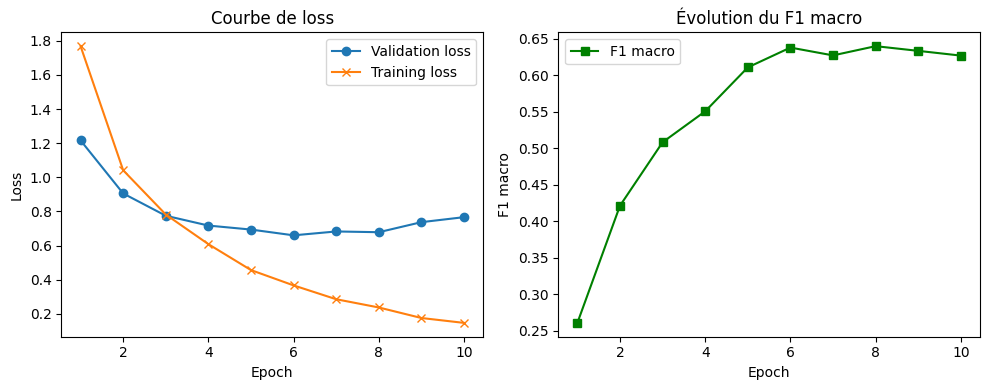


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VB       | 0.86       | ['▁i', 'ṛ', 'ẓ', 'mn']
imi          | NN       | NN       | 0.99       | ['▁imi']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
ha           | DT       | DT       | 0.93       | ['▁ha']
wnni         | PDEM     | DT       | 0.30       | ['▁w', 'nni']
iṛẓmn        | VBP      | VB       | 0.84       | ['▁i', 'ṛ', 'ẓ', 'mn']
tiṭṭawin     | NN       | NN       | 0.95       | ['▁ti', 'ṭ', 'ṭ', 'a', 'win']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
acku         | C        | C        | 0.98       | ['▁ac', 'ku']
ur           | NEG      | NEG      | 1.00       | ['▁ur']
jjin         | ADV      | ADV      | 0.93       | ['▁j', 'jin']
ẓṛin         | VB       | VBP      | 0.60       | ['▁', 'ẓ', 'ṛ', 'in']
am  

In [ ]:
# === Fine-tuning direct de XLM-RoBERTa sans pondération, sans UD mapping, avec courbes et error analysis ===

import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# === Dataset personnalisé ===
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

# === Préparation des datasets ===
train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle ===
model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === TrainingArguments ===
args = TrainingArguments(
    output_dir="./xlmr-pos-noweight",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

trainer.save_model("./xlmr-pos-noweight")

# === Error analysis : phrase longue (2× MAX_LEN) ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")

random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    has_error = False

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)

    if has_error:
        break


#### Avec UD mapping

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-8-1142455466.py:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hmidou-perso (hmidou-perso-universit-internationale-de-rabat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


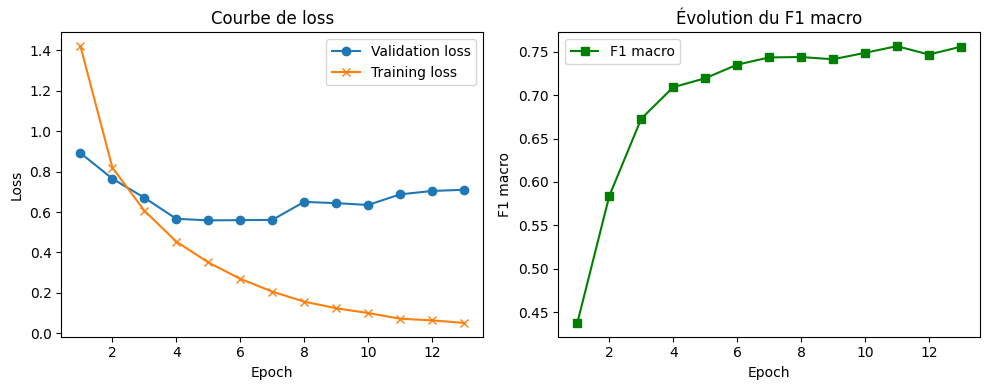


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 1.00       | ['▁i', 'ṛ', 'ẓ', 'mn']
imi          | NOUN     | NOUN     | 1.00       | ['▁imi']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
ha           | DET      | DET      | 0.91       | ['▁ha']
wnni         | DET      | DET      | 0.91       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 1.00       | ['▁i', 'ṛ', 'ẓ', 'mn']
tiṭṭawin     | NOUN     | PROPN    | 0.48       | ['▁ti', 'ṭ', 'ṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
acku         | CCONJ    | CCONJ    | 0.97       | ['▁ac', 'ku']
ur           | PART     | PART     | 1.00       | ['▁ur']
jjin         | ADV      | ADV      | 0.99       | ['▁j', 'jin']
ẓṛin         | VERB     | VERB     | 1.00       | ['▁', 'ẓ', 'ṛ', 'in']
am  

In [ ]:
# === Fine-tuning direct de XLM-RoBERTa sans pondération, avec UD mapping, avec courbes et error analysis ===

import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# === Dataset personnalisé ===
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

# === Préparation des datasets ===
train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle ===
model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === TrainingArguments ===
args = TrainingArguments(
    output_dir="./xlmr-pos-noweight",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

trainer.save_model("./xlmr-pos-noweight")

# === Error analysis : phrase longue (2× MAX_LEN) ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")

random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    has_error = False

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)

    if has_error:
        break


### Avec weighting

#### Sans UD mapping

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-11-2207409373.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


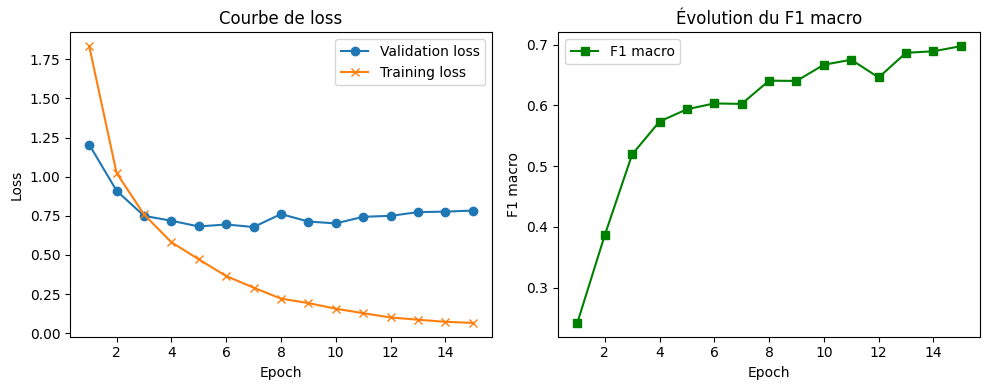


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VB       | 1.00       | ['▁i', 'ṛ', 'ẓ', 'mn']
imi          | NN       | NN       | 1.00       | ['▁imi']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
ha           | DT       | DT       | 0.99       | ['▁ha']
wnni         | PDEM     | PDEM     | 0.39       | ['▁w', 'nni']
iṛẓmn        | VBP      | VB       | 1.00       | ['▁i', 'ṛ', 'ẓ', 'mn']
tiṭṭawin     | NN       | NN       | 0.98       | ['▁ti', 'ṭ', 'ṭ', 'a', 'win']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
acku         | C        | C        | 0.97       | ['▁ac', 'ku']
ur           | NEG      | NEG      | 1.00       | ['▁ur']
jjin         | ADV      | ADV      | 0.99       | ['▁j', 'jin']
ẓṛin         | VB       | VB       | 0.54       | ['▁', 'ẓ', 'ṛ

In [ ]:
# === Imports ===
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from torch.nn import CrossEntropyLoss

# === Pondération inverse de fréquence ===
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# === Dataset personnalisé ===
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

# === Datasets ===
train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle avec injection de loss pondérée ===
model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model.compute_loss = lambda inputs, return_outputs=False: compute_loss_with_weights(model, inputs, return_outputs)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === Entraînement ===
args = TrainingArguments(
    output_dir="./xlmr-pos-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("./xlmr-pos-weighted")

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : phrase concaténée ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    has_error = False

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)

    if has_error:
        break


#### Avec UD mapping

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-2207409373.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


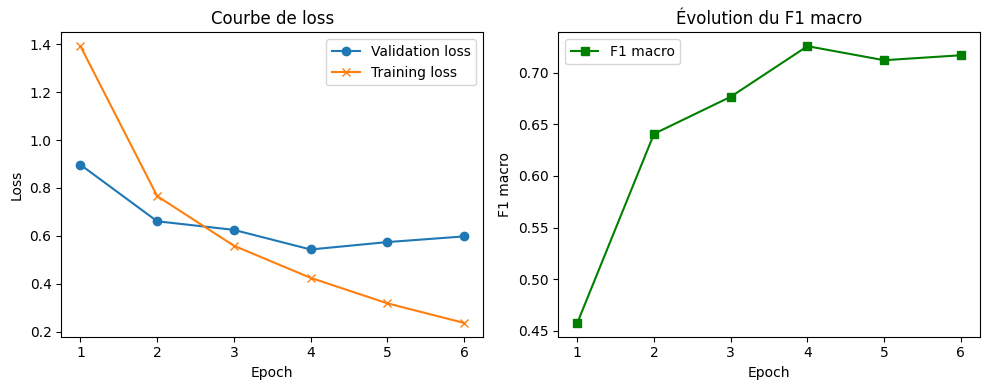


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 0.98       | ['▁i', 'ṛ', 'ẓ', 'mn']
imi          | NOUN     | NOUN     | 0.96       | ['▁imi']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
ha           | DET      | PRON     | 0.39       | ['▁ha']
wnni         | DET      | DET      | 0.79       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 0.99       | ['▁i', 'ṛ', 'ẓ', 'mn']
tiṭṭawin     | NOUN     | NOUN     | 0.90       | ['▁ti', 'ṭ', 'ṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
acku         | CCONJ    | CCONJ    | 0.72       | ['▁ac', 'ku']
ur           | PART     | PART     | 0.99       | ['▁ur']
jjin         | ADV      | ADV      | 0.64       | ['▁j', 'jin']
ẓṛin         | VERB     | VERB     | 0.99       | ['▁', 'ẓ', 'ṛ

In [ ]:
# === Imports ===
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from torch.nn import CrossEntropyLoss

# === Pondération inverse de fréquence ===
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# === Dataset personnalisé ===
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

# === Datasets ===
train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle avec injection de loss pondérée ===
model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model.compute_loss = lambda inputs, return_outputs=False: compute_loss_with_weights(model, inputs, return_outputs)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === Entraînement ===
args = TrainingArguments(
    output_dir="./xlmr-pos-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("./xlmr-pos-weighted")

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : phrase concaténée ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    has_error = False

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)

    if has_error:
        break


## Pré-fine-tuning de XLM-Roberta sur un dataset français puis re-fine-tuning sur le dataset amazigh

### Sans weighting

#### Sans UD mapping

Map:   0%|          | 0/14449 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-3823397202.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hmidou-perso (hmidou-perso-universit-internationale-de-rabat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-3823397202.py:144: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


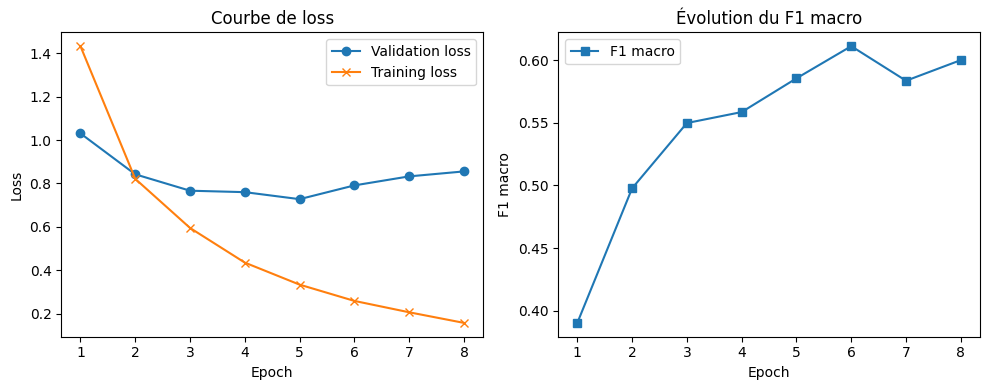


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VBP      | 0.77       | ['▁i', 'ṛ', 'ẓ', 'mn']
imi          | NN       | NN       | 0.99       | ['▁imi']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
ha           | DT       | DT       | 0.93       | ['▁ha']
wnni         | PDEM     | PDEM     | 0.42       | ['▁w', 'nni']
iṛẓmn        | VBP      | VBP      | 0.83       | ['▁i', 'ṛ', 'ẓ', 'mn']
tiṭṭawin     | NN       | NN       | 0.96       | ['▁ti', 'ṭ', 'ṭ', 'a', 'win']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
acku         | C        | C        | 0.96       | ['▁ac', 'ku']
ur           | NEG      | NEG      | 1.00       | ['▁ur']
jjin         | ADV      | ADV      | 0.91       | ['▁j', 'jin']
ẓṛin         | VB       | VB       | 0.93       | ['▁', 'ẓ', 'ṛ

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import XLMRobertaTokenizerFast, XLMRobertaForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random

# === Chargement du tokenizer XLM-R ===
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None

        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id

        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === PRÉ-FINE-TUNING XLM-RoBERTa sur corpus ANTILLES ===
def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

fr_sentences, fr_tags = load_conllu("ANTILLES/ANTILLES/train.conllu")
unique_tags_fr = sorted(set(tag for seq in fr_tags for tag in seq))
tag2id_fr = {tag: i for i, tag in enumerate(unique_tags_fr)}
id2tag_fr = {i: tag for tag, i in tag2id_fr.items()}

examples_fr = [{"tokens": s, "tags": t} for s, t in zip(fr_sentences, fr_tags)]
dataset_fr = Dataset.from_list(examples_fr).rename_columns({"tokens": "words"})
dataset_fr = dataset_fr.map(lambda x: encode_batch(x, tag2id_fr), batched=True)
dataset_fr = dataset_fr.train_test_split(test_size=0.1, seed=42)

model_fr = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=len(tag2id_fr))

args_fr = TrainingArguments(
    output_dir="./xlmr-antilles",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_fr = Trainer(
    model=model_fr,
    args=args_fr,
    train_dataset=dataset_fr["train"],
    eval_dataset=dataset_fr["test"],
    tokenizer=tokenizer
)

trainer_fr.train()
trainer_fr.save_model("./xlmr-antilles")


# === RE-FINE-TUNING XLM-RoBERTa sur corpus AMAZIGH ===

examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Charger modèle Antilles et préparer modèle Amazigh
model_fr_loaded = XLMRobertaForTokenClassification.from_pretrained("./xlmr-antilles")
model_am = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=num_labels, id2label=id2tag, label2id=tag2id)
model_am.roberta.load_state_dict(model_fr_loaded.roberta.state_dict())

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

args_am = TrainingArguments(
    output_dir="./xlmr-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./xlmr-amazigh-refinetuned")


# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()


# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Map:   0%|          | 0/14449 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-3823397202.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hmidou-perso (hmidou-perso-universit-internationale-de-rabat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-3823397202.py:144: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


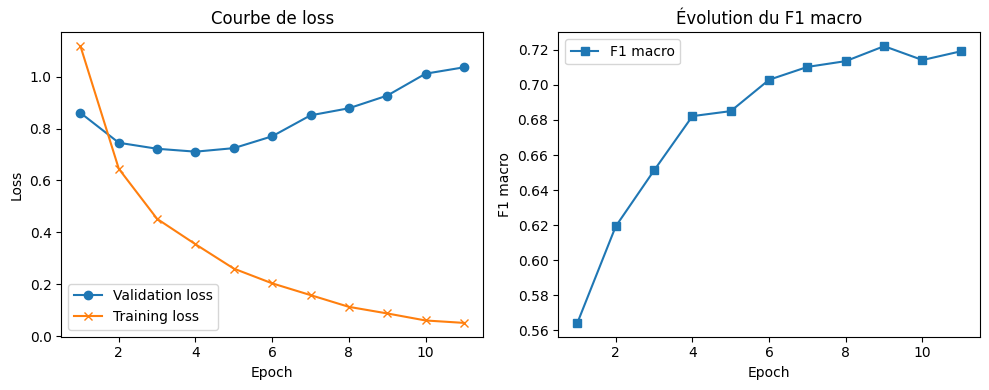


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 1.00       | ['▁i', 'ṛ', 'ẓ', 'mn']
imi          | NOUN     | NOUN     | 0.99       | ['▁imi']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
ha           | DET      | DET      | 0.99       | ['▁ha']
wnni         | DET      | DET      | 0.99       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 1.00       | ['▁i', 'ṛ', 'ẓ', 'mn']
tiṭṭawin     | NOUN     | NOUN     | 1.00       | ['▁ti', 'ṭ', 'ṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
acku         | CCONJ    | CCONJ    | 0.99       | ['▁ac', 'ku']
ur           | PART     | PART     | 1.00       | ['▁ur']
jjin         | ADV      | ADV      | 0.98       | ['▁j', 'jin']
ẓṛin         | VERB     | VERB     | 1.00       | ['▁', 'ẓ', 'ṛ

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import XLMRobertaTokenizerFast, XLMRobertaForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random

# === Chargement du tokenizer XLM-R ===
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None

        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id

        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === PRÉ-FINE-TUNING XLM-RoBERTa sur corpus ANTILLES ===
def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

fr_sentences, fr_tags = load_conllu("ANTILLES/ANTILLES/train.conllu")
unique_tags_fr = sorted(set(tag for seq in fr_tags for tag in seq))
tag2id_fr = {tag: i for i, tag in enumerate(unique_tags_fr)}
id2tag_fr = {i: tag for tag, i in tag2id_fr.items()}

examples_fr = [{"tokens": s, "tags": t} for s, t in zip(fr_sentences, fr_tags)]
dataset_fr = Dataset.from_list(examples_fr).rename_columns({"tokens": "words"})
dataset_fr = dataset_fr.map(lambda x: encode_batch(x, tag2id_fr), batched=True)
dataset_fr = dataset_fr.train_test_split(test_size=0.1, seed=42)

model_fr = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=len(tag2id_fr))

args_fr = TrainingArguments(
    output_dir="./xlmr-antilles",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_fr = Trainer(
    model=model_fr,
    args=args_fr,
    train_dataset=dataset_fr["train"],
    eval_dataset=dataset_fr["test"],
    tokenizer=tokenizer
)

trainer_fr.train()
trainer_fr.save_model("./xlmr-antilles")


# === RE-FINE-TUNING XLM-RoBERTa sur corpus AMAZIGH ===

examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Charger modèle Antilles et préparer modèle Amazigh
model_fr_loaded = XLMRobertaForTokenClassification.from_pretrained("./xlmr-antilles")
model_am = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=num_labels, id2label=id2tag, label2id=tag2id)
model_am.roberta.load_state_dict(model_fr_loaded.roberta.state_dict())

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

args_am = TrainingArguments(
    output_dir="./xlmr-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./xlmr-amazigh-refinetuned")


# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()


# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


### Avec weighting

#### Sans UD mapping

Map:   0%|          | 0/14449 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-13-2988566124.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-13-2988566124.py:160: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


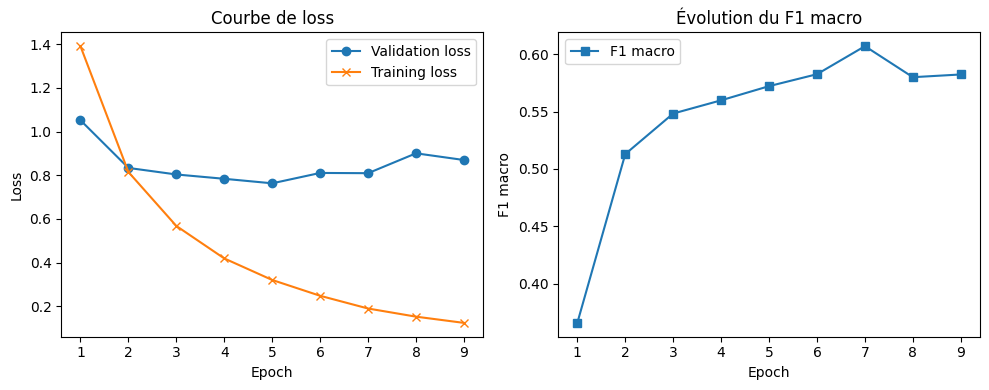


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VBP      | 0.96       | ['▁i', 'ṛ', 'ẓ', 'mn']
imi          | NN       | NN       | 0.99       | ['▁imi']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
ha           | DT       | DT       | 0.50       | ['▁ha']
wnni         | PDEM     | PDEM     | 0.78       | ['▁w', 'nni']
iṛẓmn        | VBP      | VBP      | 0.98       | ['▁i', 'ṛ', 'ẓ', 'mn']
tiṭṭawin     | NN       | NN       | 0.88       | ['▁ti', 'ṭ', 'ṭ', 'a', 'win']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
acku         | C        | C        | 0.95       | ['▁ac', 'ku']
ur           | NEG      | NEG      | 0.99       | ['▁ur']
jjin         | ADV      | ADV      | 0.97       | ['▁j', 'jin']
ẓṛin         | VB       | VB       | 0.99       | ['▁', 'ẓ', 'ṛ

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import XLMRobertaTokenizerFast, XLMRobertaForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from collections import Counter

# === Tokenizer XLM-R ===
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []
    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === Chargement corpus Antilles ===
def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

fr_sentences, fr_tags = load_conllu("ANTILLES/ANTILLES/train.conllu")
unique_tags_fr = sorted(set(tag for seq in fr_tags for tag in seq))
tag2id_fr = {tag: i for i, tag in enumerate(unique_tags_fr)}
id2tag_fr = {i: tag for tag, i in tag2id_fr.items()}

examples_fr = [{"tokens": s, "tags": t} for s, t in zip(fr_sentences, fr_tags)]
dataset_fr = Dataset.from_list(examples_fr).rename_columns({"tokens": "words"})
dataset_fr = dataset_fr.map(lambda x: encode_batch(x, tag2id_fr), batched=True)
dataset_fr = dataset_fr.train_test_split(test_size=0.1, seed=42)

model_fr = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=len(tag2id_fr))

args_fr = TrainingArguments(
    output_dir="./xlmr-antilles",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_fr = Trainer(
    model=model_fr,
    args=args_fr,
    train_dataset=dataset_fr["train"],
    eval_dataset=dataset_fr["test"],
    tokenizer=tokenizer
)

trainer_fr.train()
trainer_fr.save_model("./xlmr-antilles")

# === RE-FINE-TUNING XLM-R SUR CORPUS AMAZIGH (PONDÉRÉ) ===

# Dataset Amazigh HuggingFace
examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Calcul pondération des classes
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# Chargement du modèle avec transfert
model_fr_loaded = XLMRobertaForTokenClassification.from_pretrained("./xlmr-antilles")
model_am = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=num_labels, id2label=id2tag, label2id=tag2id)
model_am.roberta.load_state_dict(model_fr_loaded.roberta.state_dict())

# Fonction de perte pondérée
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model_am.compute_loss = compute_loss_with_weights

# Métriques
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# Entraînement final
args_am = TrainingArguments(
    output_dir="./xlmr-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./xlmr-amazigh-refinetuned")

# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Analyse d'erreur sur phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

Map:   0%|          | 0/14449 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-14-2988566124.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-14-2988566124.py:160: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


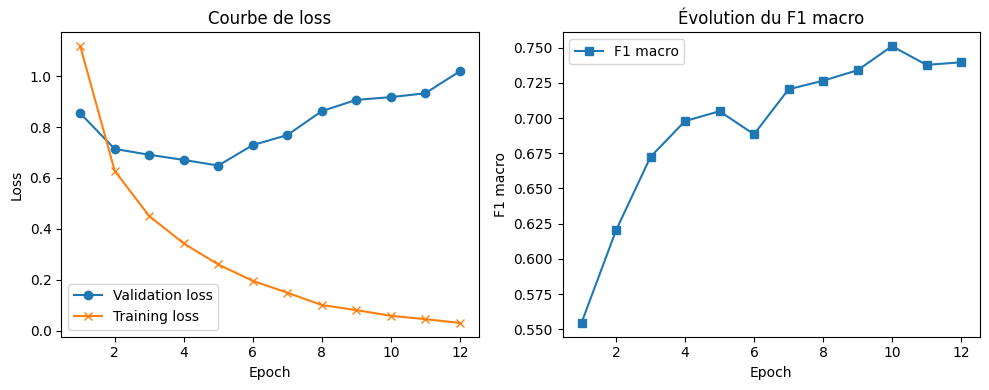


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 1.00       | ['▁i', 'ṛ', 'ẓ', 'mn']
imi          | NOUN     | NOUN     | 1.00       | ['▁imi']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
ha           | DET      | DET      | 0.99       | ['▁ha']
wnni         | DET      | DET      | 1.00       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 1.00       | ['▁i', 'ṛ', 'ẓ', 'mn']
tiṭṭawin     | NOUN     | NOUN     | 1.00       | ['▁ti', 'ṭ', 'ṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
acku         | CCONJ    | CCONJ    | 1.00       | ['▁ac', 'ku']
ur           | PART     | PART     | 1.00       | ['▁ur']
jjin         | ADV      | ADV      | 0.99       | ['▁j', 'jin']
ẓṛin         | VERB     | VERB     | 1.00       | ['▁', 'ẓ', 'ṛ

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import XLMRobertaTokenizerFast, XLMRobertaForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from collections import Counter

# === Tokenizer XLM-R ===
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []
    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === Chargement corpus Antilles ===
def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

fr_sentences, fr_tags = load_conllu("ANTILLES/ANTILLES/train.conllu")
unique_tags_fr = sorted(set(tag for seq in fr_tags for tag in seq))
tag2id_fr = {tag: i for i, tag in enumerate(unique_tags_fr)}
id2tag_fr = {i: tag for tag, i in tag2id_fr.items()}

examples_fr = [{"tokens": s, "tags": t} for s, t in zip(fr_sentences, fr_tags)]
dataset_fr = Dataset.from_list(examples_fr).rename_columns({"tokens": "words"})
dataset_fr = dataset_fr.map(lambda x: encode_batch(x, tag2id_fr), batched=True)
dataset_fr = dataset_fr.train_test_split(test_size=0.1, seed=42)

model_fr = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=len(tag2id_fr))

args_fr = TrainingArguments(
    output_dir="./xlmr-antilles",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_fr = Trainer(
    model=model_fr,
    args=args_fr,
    train_dataset=dataset_fr["train"],
    eval_dataset=dataset_fr["test"],
    tokenizer=tokenizer
)

trainer_fr.train()
trainer_fr.save_model("./xlmr-antilles")

# === RE-FINE-TUNING XLM-R SUR CORPUS AMAZIGH (PONDÉRÉ) ===

# Dataset Amazigh HuggingFace
examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Calcul pondération des classes
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# Chargement du modèle avec transfert
model_fr_loaded = XLMRobertaForTokenClassification.from_pretrained("./xlmr-antilles")
model_am = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=num_labels, id2label=id2tag, label2id=tag2id)
model_am.roberta.load_state_dict(model_fr_loaded.roberta.state_dict())

# Fonction de perte pondérée
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model_am.compute_loss = compute_loss_with_weights

# Métriques
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# Entraînement final
args_am = TrainingArguments(
    output_dir="./xlmr-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./xlmr-amazigh-refinetuned")

# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Analyse d'erreur sur phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


## Fine-tuning direct de BERTu sur le dataset amazigh

### Sans weighting

#### Sans mapping UD

Map:   0%|          | 0/630 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-23-3575327452.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


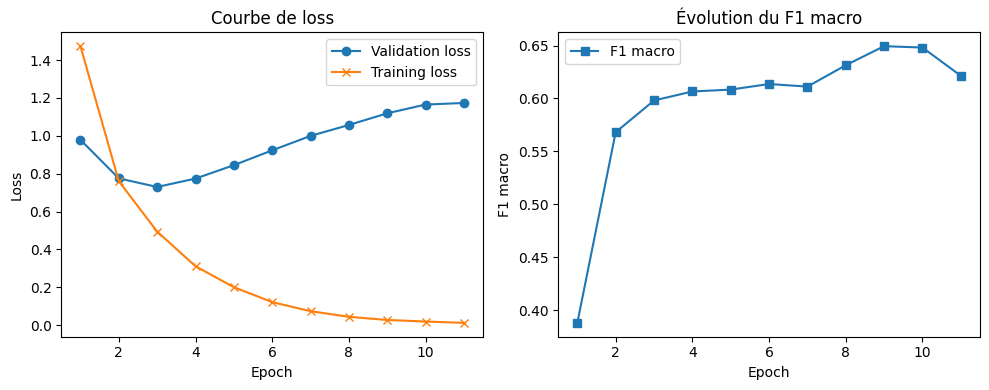


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | NN       | 0.68       | ['[UNK]']
imi          | NN       | NN       | 0.99       | ['im', '##i']
!            | PUNC     | PUNC     | 1.00       | ['!']
ha           | DT       | C        | 0.55       | ['ha']
wnni         | PDEM     | PDEM     | 0.30       | ['w', '##nn', '##i']
iṛẓmn        | VBP      | S        | 0.87       | ['[UNK]']
tiṭṭawin     | NN       | NN       | 1.00       | ['[UNK]']
!            | PUNC     | PUNC     | 1.00       | ['!']
acku         | C        | C        | 1.00       | ['ac', '##ku']
ur           | NEG      | NEG      | 1.00       | ['ur']
jjin         | ADV      | ADV      | 1.00       | ['jj', '##in']
ẓṛin         | VB       | VB       | 0.89       | ['[UNK]']
am           | ADV      | C        | 0.61       | ['

In [ ]:
# === Imports ===
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Tokenizer BERTu ===
tokenizer = AutoTokenizer.from_pretrained("mlrs/bertu")

# === Encodage ===
def encode_batch(batch):
    tokenized = tokenizer(batch["words"], is_split_into_words=True,
                          padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)

    tokenized["labels"] = labels
    return tokenized

# === Préparer les datasets ===
train_dataset = Dataset.from_list([{"words": w, "tags": t} for w, t in train_data])
val_dataset   = Dataset.from_list([{"words": w, "tags": t} for w, t in val_data])
test_dataset  = Dataset.from_list([{"words": w, "tags": t} for w, t in test_data])

# === Appliquer l'encodage ===
train_dataset = train_dataset.map(encode_batch, batched=True)
val_dataset   = val_dataset.map(encode_batch, batched=True)
test_dataset  = test_dataset.map(encode_batch, batched=True)

# === Modèle BERTu ===
model = AutoModelForTokenClassification.from_pretrained(
    "mlrs/bertu",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === TrainingArguments ===
args = TrainingArguments(
    output_dir="./bertu-amazigh-pos",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Entraînement ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("./bertu-amazigh-pos")

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("f1_macro", None) or entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : phrase longue (2× MAX_LEN) ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")

random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    has_error = False

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)

    if has_error:
        break


#### Avec mapping UD

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/630 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-15-3575327452.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


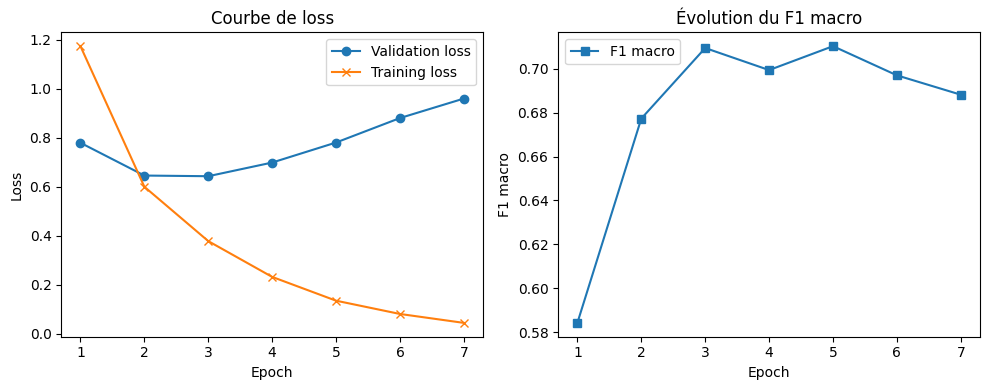


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | NOUN     | 0.95       | ['[UNK]']
imi          | NOUN     | NOUN     | 0.99       | ['im', '##i']
!            | PUNCT    | PUNCT    | 1.00       | ['!']
ha           | DET      | DET      | 0.95       | ['ha']
wnni         | DET      | PRON     | 0.36       | ['w', '##nn', '##i']
iṛẓmn        | VERB     | PROPN    | 0.33       | ['[UNK]']
tiṭṭawin     | NOUN     | NOUN     | 0.88       | ['[UNK]']
!            | PUNCT    | PUNCT    | 1.00       | ['!']
acku         | CCONJ    | CCONJ    | 0.99       | ['ac', '##ku']
ur           | PART     | PART     | 1.00       | ['ur']
jjin         | ADV      | ADV      | 0.87       | ['jj', '##in']
ẓṛin         | VERB     | VERB     | 0.85       | ['[UNK]']
am           | ADV      | ADV      | 0.61       | ['

In [ ]:
# === Imports ===
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Tokenizer BERTu ===
tokenizer = AutoTokenizer.from_pretrained("mlrs/bertu")

# === Encodage ===
def encode_batch(batch):
    tokenized = tokenizer(batch["words"], is_split_into_words=True,
                          padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)

    tokenized["labels"] = labels
    return tokenized

# === Préparer les datasets ===
train_dataset = Dataset.from_list([{"words": w, "tags": t} for w, t in train_data])
val_dataset   = Dataset.from_list([{"words": w, "tags": t} for w, t in val_data])
test_dataset  = Dataset.from_list([{"words": w, "tags": t} for w, t in test_data])

# === Appliquer l'encodage ===
train_dataset = train_dataset.map(encode_batch, batched=True)
val_dataset   = val_dataset.map(encode_batch, batched=True)
test_dataset  = test_dataset.map(encode_batch, batched=True)

# === Modèle BERTu ===
model = AutoModelForTokenClassification.from_pretrained(
    "mlrs/bertu",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === TrainingArguments ===
args = TrainingArguments(
    output_dir="./bertu-amazigh-pos",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Entraînement ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("./bertu-amazigh-pos")

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("f1_macro", None) or entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : phrase longue (2× MAX_LEN) ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")

random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    has_error = False

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)

    if has_error:
        break


### Avec weighting

#### Sans UD mapping

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/630 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-8-3974513129.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


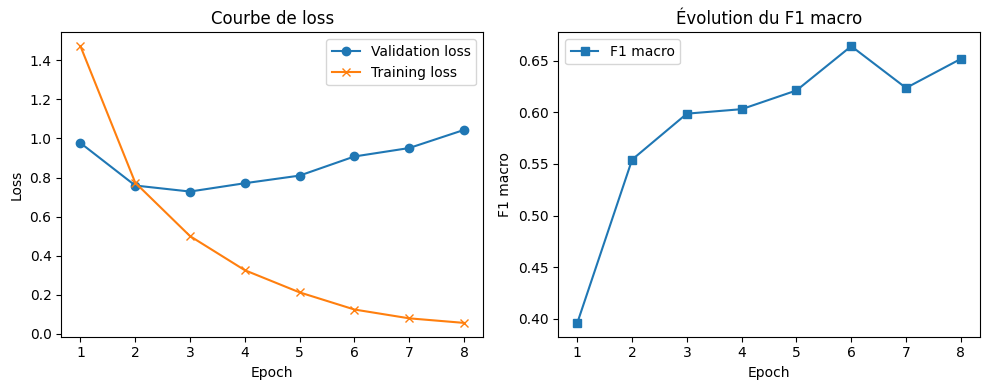


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VB       | 0.86       | ['[UNK]']
imi          | NN       | NN       | 1.00       | ['im', '##i']
!            | PUNC     | PUNC     | 1.00       | ['!']
ha           | DT       | DT       | 0.64       | ['ha']
wnni         | PDEM     | PDEM     | 0.46       | ['w', '##nn', '##i']
iṛẓmn        | VBP      | VB       | 0.50       | ['[UNK]']
tiṭṭawin     | NN       | NN       | 0.81       | ['[UNK]']
!            | PUNC     | PUNC     | 1.00       | ['!']
acku         | C        | C        | 0.99       | ['ac', '##ku']
ur           | NEG      | NEG      | 0.99       | ['ur']
jjin         | ADV      | ADV      | 0.96       | ['jj', '##in']
ẓṛin         | VB       | VB       | 0.83       | ['[UNK]']
am           | ADV      | C        | 0.

In [ ]:
# === Imports ===
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from collections import Counter
from torch.nn import CrossEntropyLoss

# === Tokenizer BERTu ===
tokenizer = AutoTokenizer.from_pretrained("mlrs/bertu")

# === Encodage ===
def encode_batch(batch):
    tokenized = tokenizer(batch["words"], is_split_into_words=True,
                          padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)

    tokenized["labels"] = labels
    return tokenized

# === Préparation des datasets ===
train_dataset = Dataset.from_list([{"words": w, "tags": t} for w, t in train_data])
val_dataset   = Dataset.from_list([{"words": w, "tags": t} for w, t in val_data])
test_dataset  = Dataset.from_list([{"words": w, "tags": t} for w, t in test_data])

train_dataset = train_dataset.map(encode_batch, batched=True)
val_dataset   = val_dataset.map(encode_batch, batched=True)
test_dataset  = test_dataset.map(encode_batch, batched=True)

# === Pondération inverse de fréquence ===
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# === Modèle BERTu ===
model = AutoModelForTokenClassification.from_pretrained(
    "mlrs/bertu",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Fonction de perte pondérée ===
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model.compute_loss = compute_loss_with_weights

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === Entraînement ===
args = TrainingArguments(
    output_dir="./bertu-amazigh-pos-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("./bertu-amazigh-pos-weighted")

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

Map:   0%|          | 0/630 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-16-3974513129.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


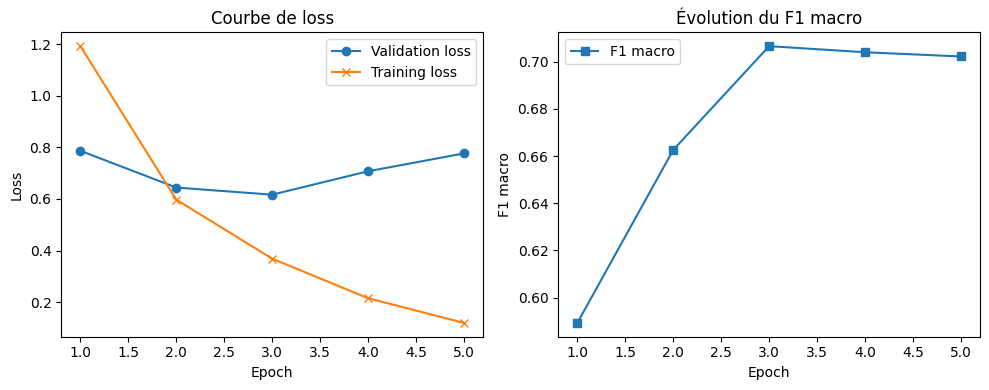


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | NOUN     | 0.52       | ['[UNK]']
imi          | NOUN     | NOUN     | 0.57       | ['im', '##i']
!            | PUNCT    | PUNCT    | 1.00       | ['!']
ha           | DET      | ADP      | 0.40       | ['ha']
wnni         | DET      | PRON     | 0.40       | ['w', '##nn', '##i']
iṛẓmn        | VERB     | ADP      | 0.66       | ['[UNK]']
tiṭṭawin     | NOUN     | NOUN     | 0.70       | ['[UNK]']
!            | PUNCT    | PUNCT    | 1.00       | ['!']
acku         | CCONJ    | CCONJ    | 0.97       | ['ac', '##ku']
ur           | PART     | PART     | 0.99       | ['ur']
jjin         | ADV      | ADV      | 0.85       | ['jj', '##in']
ẓṛin         | VERB     | VERB     | 0.44       | ['[UNK]']
am           | ADV      | CCONJ    | 0.

In [ ]:
# === Imports ===
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from collections import Counter
from torch.nn import CrossEntropyLoss

# === Tokenizer BERTu ===
tokenizer = AutoTokenizer.from_pretrained("mlrs/bertu")

# === Encodage ===
def encode_batch(batch):
    tokenized = tokenizer(batch["words"], is_split_into_words=True,
                          padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)

    tokenized["labels"] = labels
    return tokenized

# === Préparation des datasets ===
train_dataset = Dataset.from_list([{"words": w, "tags": t} for w, t in train_data])
val_dataset   = Dataset.from_list([{"words": w, "tags": t} for w, t in val_data])
test_dataset  = Dataset.from_list([{"words": w, "tags": t} for w, t in test_data])

train_dataset = train_dataset.map(encode_batch, batched=True)
val_dataset   = val_dataset.map(encode_batch, batched=True)
test_dataset  = test_dataset.map(encode_batch, batched=True)

# === Pondération inverse de fréquence ===
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# === Modèle BERTu ===
model = AutoModelForTokenClassification.from_pretrained(
    "mlrs/bertu",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Fonction de perte pondérée ===
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model.compute_loss = compute_loss_with_weights

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === Entraînement ===
args = TrainingArguments(
    output_dir="./bertu-amazigh-pos-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("./bertu-amazigh-pos-weighted")

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


## Pré-fine-tuning sur un dataset maltais + re-fine-tuning sur le dataset amazigh

### Sans weighting

#### Sans UD mapping

Map:   0%|          | 0/1123 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-20-965311502.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_mt = Trainer(


Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

/tmp/ipython-input-20-965311502.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


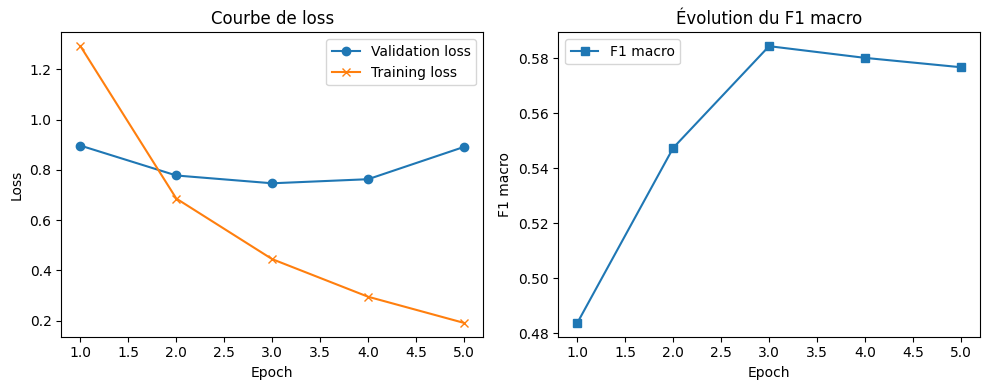


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | NN       | 0.43       | ['[UNK]']
imi          | NN       | NN       | 0.92       | ['im', '##i']
!            | PUNC     | PUNC     | 1.00       | ['!']
ha           | DT       | DT       | 0.68       | ['ha']
wnni         | PDEM     | PDEM     | 0.33       | ['w', '##nn', '##i']
iṛẓmn        | VBP      | NN       | 0.49       | ['[UNK]']
tiṭṭawin     | NN       | NN       | 0.81       | ['[UNK]']
!            | PUNC     | PUNC     | 1.00       | ['!']
acku         | C        | C        | 0.98       | ['ac', '##ku']
ur           | NEG      | NEG      | 0.98       | ['ur']
jjin         | ADV      | ADV      | 0.74       | ['jj', '##in']
ẓṛin         | VB       | VB       | 0.71       | ['[UNK]']
am           | ADV      | ADV      | 0.

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random


# === Tokenizer BERTu ===
tokenizer = AutoTokenizer.from_pretrained("mlrs/bertu")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None

        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id

        labels.append(label)
    tokenized["labels"] = labels
    return tokenized


# === PRÉ-FINE-TUNING BERTu sur corpus MALTAIS ===

def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

mt_sentences, mt_tags = load_conllu("mt_mudt-ud-train.conllu")
unique_tags_mt = sorted(set(tag for seq in mt_tags for tag in seq))
tag2id_mt = {tag: i for i, tag in enumerate(unique_tags_mt)}
id2tag_mt = {i: tag for tag, i in tag2id_mt.items()}

examples_mt = [{"tokens": s, "tags": t} for s, t in zip(mt_sentences, mt_tags)]
dataset_mt = Dataset.from_list(examples_mt)
dataset_mt = dataset_mt.rename_columns({"tokens": "words"})
dataset_mt = dataset_mt.map(lambda x: encode_batch(x, tag2id_mt), batched=True)
dataset_mt = dataset_mt.train_test_split(test_size=0.1, seed=42)

model_mt = AutoModelForTokenClassification.from_pretrained("mlrs/bertu", num_labels=len(tag2id_mt))

args_mt = TrainingArguments(
    output_dir="./bertu-mt",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_mt = Trainer(
    model=model_mt,
    args=args_mt,
    train_dataset=dataset_mt["train"],
    eval_dataset=dataset_mt["test"],
    tokenizer=tokenizer
)

trainer_mt.train()
trainer_mt.save_model("./bertu-mt")


# === RE-FINE-TUNING BERTu sur corpus AMAZIGH ===

# Charger modèle Maltais et préparer modèle Amazigh
model_mt_loaded = AutoModelForTokenClassification.from_pretrained("./bertu-mt")
model_am = AutoModelForTokenClassification.from_pretrained("mlrs/bertu", num_labels=num_labels, id2label=id2tag, label2id=tag2id)
model_am.bert.load_state_dict(model_mt_loaded.bert.state_dict())

examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }


args_am = TrainingArguments(
    output_dir="./bertu-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./bertu-amazigh-refinetuned")


# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()


# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

Map:   0%|          | 0/1123 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-17-965311502.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_mt = Trainer(


Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

/tmp/ipython-input-17-965311502.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


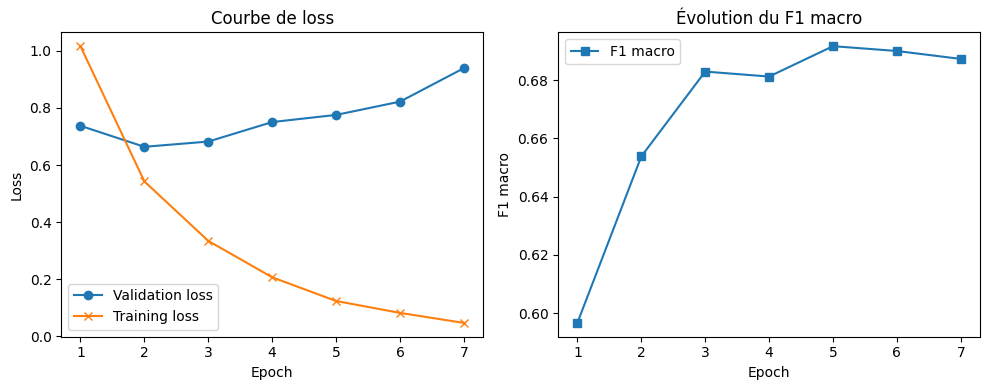


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 0.98       | ['[UNK]']
imi          | NOUN     | NOUN     | 1.00       | ['im', '##i']
!            | PUNCT    | PUNCT    | 1.00       | ['!']
ha           | DET      | DET      | 0.99       | ['ha']
wnni         | DET      | DET      | 0.83       | ['w', '##nn', '##i']
iṛẓmn        | VERB     | VERB     | 0.93       | ['[UNK]']
tiṭṭawin     | NOUN     | NOUN     | 0.96       | ['[UNK]']
!            | PUNCT    | PUNCT    | 1.00       | ['!']
acku         | CCONJ    | CCONJ    | 0.99       | ['ac', '##ku']
ur           | PART     | PART     | 0.99       | ['ur']
jjin         | ADV      | ADV      | 0.99       | ['jj', '##in']
ẓṛin         | VERB     | VERB     | 0.98       | ['[UNK]']
am           | ADV      | ADV      | 0.

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random


# === Tokenizer BERTu ===
tokenizer = AutoTokenizer.from_pretrained("mlrs/bertu")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None

        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id

        labels.append(label)
    tokenized["labels"] = labels
    return tokenized


# === PRÉ-FINE-TUNING BERTu sur corpus MALTAIS ===

def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

mt_sentences, mt_tags = load_conllu("mt_mudt-ud-train.conllu")
unique_tags_mt = sorted(set(tag for seq in mt_tags for tag in seq))
tag2id_mt = {tag: i for i, tag in enumerate(unique_tags_mt)}
id2tag_mt = {i: tag for tag, i in tag2id_mt.items()}

examples_mt = [{"tokens": s, "tags": t} for s, t in zip(mt_sentences, mt_tags)]
dataset_mt = Dataset.from_list(examples_mt)
dataset_mt = dataset_mt.rename_columns({"tokens": "words"})
dataset_mt = dataset_mt.map(lambda x: encode_batch(x, tag2id_mt), batched=True)
dataset_mt = dataset_mt.train_test_split(test_size=0.1, seed=42)

model_mt = AutoModelForTokenClassification.from_pretrained("mlrs/bertu", num_labels=len(tag2id_mt))

args_mt = TrainingArguments(
    output_dir="./bertu-mt",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_mt = Trainer(
    model=model_mt,
    args=args_mt,
    train_dataset=dataset_mt["train"],
    eval_dataset=dataset_mt["test"],
    tokenizer=tokenizer
)

trainer_mt.train()
trainer_mt.save_model("./bertu-mt")


# === RE-FINE-TUNING BERTu sur corpus AMAZIGH ===

# Charger modèle Maltais et préparer modèle Amazigh
model_mt_loaded = AutoModelForTokenClassification.from_pretrained("./bertu-mt")
model_am = AutoModelForTokenClassification.from_pretrained("mlrs/bertu", num_labels=num_labels, id2label=id2tag, label2id=tag2id)
model_am.bert.load_state_dict(model_mt_loaded.bert.state_dict())

examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }


args_am = TrainingArguments(
    output_dir="./bertu-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./bertu-amazigh-refinetuned")


# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()


# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


### Avec weighting

#### Sans UD mapping

Map:   0%|          | 0/1123 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-2499019704.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_mt = Trainer(


Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

/tmp/ipython-input-10-2499019704.py:162: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


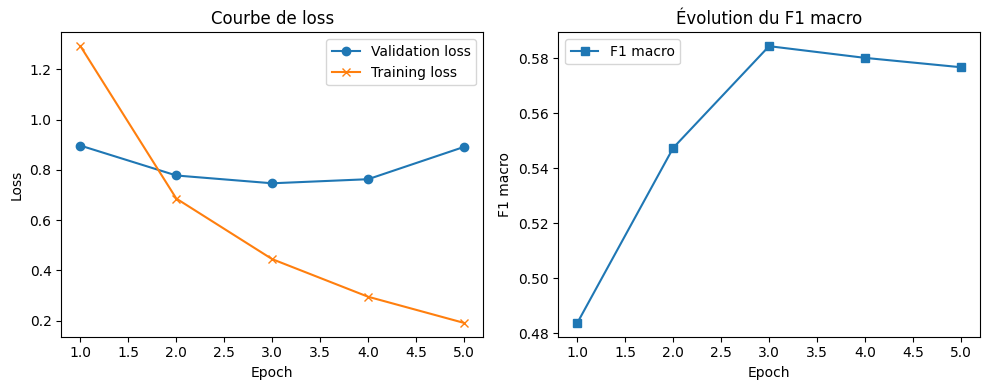


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | NN       | 0.43       | ['[UNK]']
imi          | NN       | NN       | 0.92       | ['im', '##i']
!            | PUNC     | PUNC     | 1.00       | ['!']
ha           | DT       | DT       | 0.68       | ['ha']
wnni         | PDEM     | PDEM     | 0.33       | ['w', '##nn', '##i']
iṛẓmn        | VBP      | NN       | 0.49       | ['[UNK]']
tiṭṭawin     | NN       | NN       | 0.81       | ['[UNK]']
!            | PUNC     | PUNC     | 1.00       | ['!']
acku         | C        | C        | 0.98       | ['ac', '##ku']
ur           | NEG      | NEG      | 0.98       | ['ur']
jjin         | ADV      | ADV      | 0.74       | ['jj', '##in']
ẓṛin         | VB       | VB       | 0.71       | ['[UNK]']
am           | ADV      | ADV      | 0.

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from collections import Counter
from torch.nn import CrossEntropyLoss

# === Tokenizer BERTu ===
tokenizer = AutoTokenizer.from_pretrained("mlrs/bertu")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []
    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === PRÉ-FINE-TUNING BERTu sur corpus MALTAIS ===
def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

mt_sentences, mt_tags = load_conllu("mt_mudt-ud-train.conllu")
unique_tags_mt = sorted(set(tag for seq in mt_tags for tag in seq))
tag2id_mt = {tag: i for i, tag in enumerate(unique_tags_mt)}
id2tag_mt = {i: tag for tag, i in tag2id_mt.items()}

examples_mt = [{"tokens": s, "tags": t} for s, t in zip(mt_sentences, mt_tags)]
dataset_mt = Dataset.from_list(examples_mt)
dataset_mt = dataset_mt.rename_columns({"tokens": "words"})
dataset_mt = dataset_mt.map(lambda x: encode_batch(x, tag2id_mt), batched=True)
dataset_mt = dataset_mt.train_test_split(test_size=0.1, seed=42)

model_mt = AutoModelForTokenClassification.from_pretrained("mlrs/bertu", num_labels=len(tag2id_mt))

args_mt = TrainingArguments(
    output_dir="./bertu-mt",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_mt = Trainer(
    model=model_mt,
    args=args_mt,
    train_dataset=dataset_mt["train"],
    eval_dataset=dataset_mt["test"],
    tokenizer=tokenizer
)

trainer_mt.train()
trainer_mt.save_model("./bertu-mt")


# === RE-FINE-TUNING PONDÉRÉ BERTu sur corpus AMAZIGH ===

# Calcul des poids uniquement sur train_data
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# Charger modèle pré-finetuné et nouveau modèle final
model_mt_loaded = AutoModelForTokenClassification.from_pretrained("./bertu-mt")
model_am = AutoModelForTokenClassification.from_pretrained("mlrs/bertu", num_labels=num_labels, id2label=id2tag, label2id=tag2id)
model_am.bert.load_state_dict(model_mt_loaded.bert.state_dict())

# Injecter la fonction de loss pondérée
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model_am.compute_loss = lambda inputs, return_outputs=False: compute_loss_with_weights(model_am, inputs, return_outputs)

# Construction du dataset HuggingFace
examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Métriques
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

args_am = TrainingArguments(
    output_dir="./bertu-amazigh-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./bertu-amazigh-weighted")


# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()


# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

Map:   0%|          | 0/1123 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-18-2499019704.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_mt = Trainer(


Some weights of BertForTokenClassification were not initialized from the model checkpoint at mlrs/bertu and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

/tmp/ipython-input-18-2499019704.py:162: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


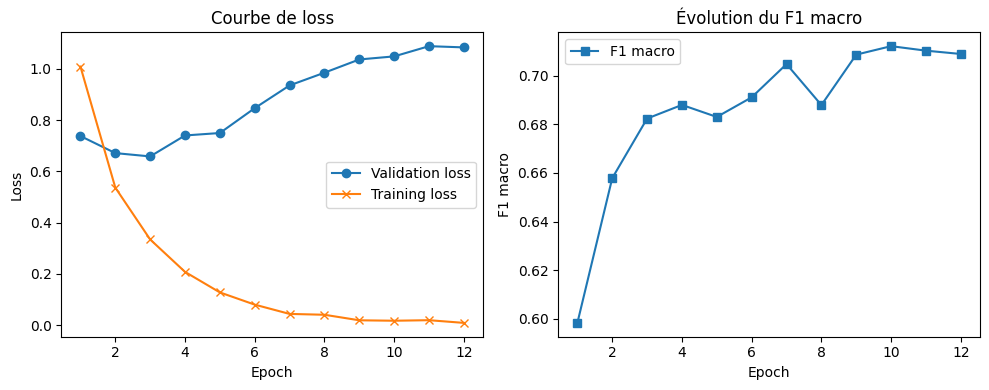


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 0.87       | ['[UNK]']
imi          | NOUN     | NOUN     | 1.00       | ['im', '##i']
!            | PUNCT    | PUNCT    | 1.00       | ['!']
ha           | DET      | DET      | 1.00       | ['ha']
wnni         | DET      | DET      | 1.00       | ['w', '##nn', '##i']
iṛẓmn        | VERB     | VERB     | 1.00       | ['[UNK]']
tiṭṭawin     | NOUN     | NOUN     | 1.00       | ['[UNK]']
!            | PUNCT    | PUNCT    | 1.00       | ['!']
acku         | CCONJ    | CCONJ    | 1.00       | ['ac', '##ku']
ur           | PART     | PART     | 1.00       | ['ur']
jjin         | ADV      | ADV      | 1.00       | ['jj', '##in']
ẓṛin         | VERB     | VERB     | 0.84       | ['[UNK]']
am           | ADV      | ADV      | 0.

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from collections import Counter
from torch.nn import CrossEntropyLoss

# === Tokenizer BERTu ===
tokenizer = AutoTokenizer.from_pretrained("mlrs/bertu")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []
    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === PRÉ-FINE-TUNING BERTu sur corpus MALTAIS ===
def load_conllu(file_path):
    sentences, pos_tags = [], []
    with open(file_path, encoding='utf-8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    pos_tags.append(tags)
                    tokens, tags = [], []
            elif not line.startswith("#"):
                parts = line.split("\t")
                if len(parts) >= 4 and "-" not in parts[0]:
                    tokens.append(parts[1])
                    tags.append(parts[3])
    return sentences, pos_tags

mt_sentences, mt_tags = load_conllu("mt_mudt-ud-train.conllu")
unique_tags_mt = sorted(set(tag for seq in mt_tags for tag in seq))
tag2id_mt = {tag: i for i, tag in enumerate(unique_tags_mt)}
id2tag_mt = {i: tag for tag, i in tag2id_mt.items()}

examples_mt = [{"tokens": s, "tags": t} for s, t in zip(mt_sentences, mt_tags)]
dataset_mt = Dataset.from_list(examples_mt)
dataset_mt = dataset_mt.rename_columns({"tokens": "words"})
dataset_mt = dataset_mt.map(lambda x: encode_batch(x, tag2id_mt), batched=True)
dataset_mt = dataset_mt.train_test_split(test_size=0.1, seed=42)

model_mt = AutoModelForTokenClassification.from_pretrained("mlrs/bertu", num_labels=len(tag2id_mt))

args_mt = TrainingArguments(
    output_dir="./bertu-mt",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_mt = Trainer(
    model=model_mt,
    args=args_mt,
    train_dataset=dataset_mt["train"],
    eval_dataset=dataset_mt["test"],
    tokenizer=tokenizer
)

trainer_mt.train()
trainer_mt.save_model("./bertu-mt")


# === RE-FINE-TUNING PONDÉRÉ BERTu sur corpus AMAZIGH ===

# Calcul des poids uniquement sur train_data
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# Charger modèle pré-finetuné et nouveau modèle final
model_mt_loaded = AutoModelForTokenClassification.from_pretrained("./bertu-mt")
model_am = AutoModelForTokenClassification.from_pretrained("mlrs/bertu", num_labels=num_labels, id2label=id2tag, label2id=tag2id)
model_am.bert.load_state_dict(model_mt_loaded.bert.state_dict())

# Injecter la fonction de loss pondérée
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model_am.compute_loss = lambda inputs, return_outputs=False: compute_loss_with_weights(model_am, inputs, return_outputs)

# Construction du dataset HuggingFace
examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Métriques
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

args_am = TrainingArguments(
    output_dir="./bertu-amazigh-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./bertu-amazigh-weighted")


# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()


# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()

    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)

    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


## Fine-tuning direct de AfriBERTa sur le dataset amazigh

### Sans weighting

#### Sans UD mapping

tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-24-2748750025.py:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/446M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

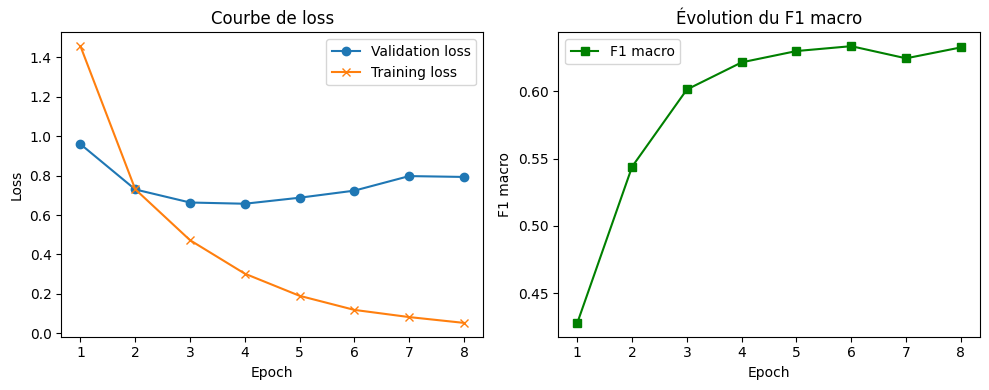


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VB       | 1.00       | ['▁i', 'ṛẓ', 'm', 'n']
imi          | NN       | NN       | 0.99       | ['▁imi']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
ha           | DT       | DT       | 0.54       | ['▁ha']
wnni         | PDEM     | PDEM     | 0.49       | ['▁w', 'nni']
iṛẓmn        | VBP      | VB       | 0.90       | ['▁i', 'ṛẓ', 'm', 'n']
tiṭṭawin     | NN       | NN       | 1.00       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
acku         | C        | C        | 0.99       | ['▁a', 'c', 'ku']
ur           | NEG      | NEG      | 1.00       | ['▁u', 'r']
jjin         | ADV      | VB       | 1.00       | ['▁', 'jji', 'n']
ẓṛin         | VB       | VB       | 0.66       | ['▁', 'ẓṛ', 'in']


In [ ]:
# === Fine-tuning direct de AfriBERTa sur corpus amazigh, sans weighting et sans UD mapping ===

import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Tokenizer AfriBERTa ===
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_base")

# === Dataset personnalisé ===
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

# === Création des datasets ===
train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle ===
model = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === Arguments d'entraînement ===
args = TrainingArguments(
    output_dir="./afriberta-pos-noweight",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Entraîneur ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("./afriberta-pos-noweight")

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-19-2300547024.py:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/446M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

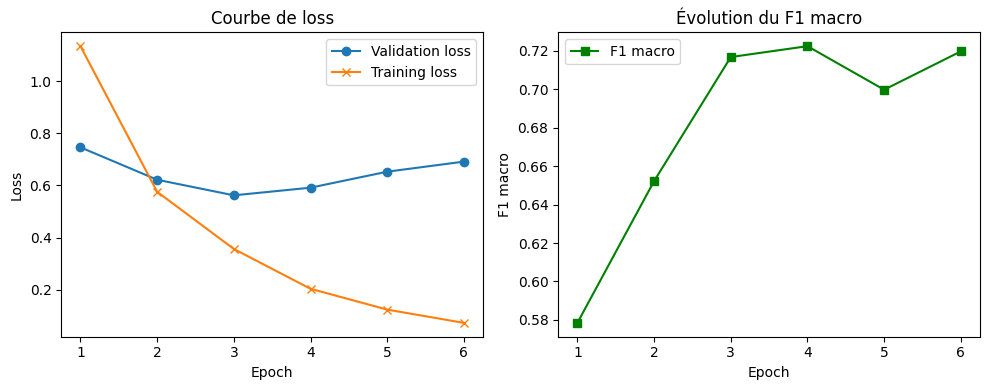


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 0.92       | ['▁i', 'ṛẓ', 'm', 'n']
imi          | NOUN     | NOUN     | 0.97       | ['▁imi']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
ha           | DET      | DET      | 0.90       | ['▁ha']
wnni         | DET      | DET      | 0.88       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 0.92       | ['▁i', 'ṛẓ', 'm', 'n']
tiṭṭawin     | NOUN     | NOUN     | 0.99       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
acku         | CCONJ    | CCONJ    | 0.85       | ['▁a', 'c', 'ku']
ur           | PART     | PART     | 0.99       | ['▁u', 'r']
jjin         | ADV      | VERB     | 0.94       | ['▁', 'jji', 'n']
ẓṛin         | VERB     | ADV      | 0.52       | ['▁', 'ẓṛ', 'in']


In [ ]:
# === Fine-tuning direct de AfriBERTa sur corpus amazigh, sans weighting et avec UD mapping ===

import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Tokenizer AfriBERTa ===
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_base")

# === Dataset personnalisé ===
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

# === Création des datasets ===
train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle ===
model = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === Arguments d'entraînement ===
args = TrainingArguments(
    output_dir="./afriberta-pos-noweight",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Entraîneur ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("./afriberta-pos-noweight")

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


### Avec weighting

#### Sans UD mapping

tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-11-3787565347.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/446M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

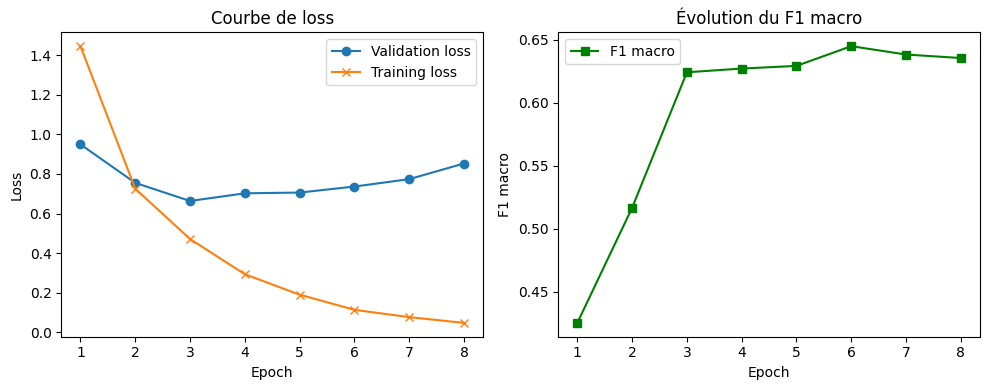


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VB       | 0.86       | ['▁i', 'ṛẓ', 'm', 'n']
imi          | NN       | NN       | 0.99       | ['▁imi']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
ha           | DT       | DT       | 0.86       | ['▁ha']
wnni         | PDEM     | PDEM     | 0.64       | ['▁w', 'nni']
iṛẓmn        | VBP      | VBP      | 0.36       | ['▁i', 'ṛẓ', 'm', 'n']
tiṭṭawin     | NN       | NN       | 1.00       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
acku         | C        | C        | 0.98       | ['▁a', 'c', 'ku']
ur           | NEG      | NEG      | 1.00       | ['▁u', 'r']
jjin         | ADV      | VB       | 0.77       | ['▁', 'jji', 'n']
ẓṛin         | VB       | ADV      | 0.85       | ['▁', 'ẓṛ', 'in']


In [ ]:
# === Imports ===
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Calcul des poids de classes ===
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# === Tokenizer AfriBERTa ===
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_base")

# === Dataset personnalisé ===
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

# === Datasets ===
train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle AfriBERTa ===
model = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Ajout du compute_loss pondéré ===
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model.compute_loss = lambda inputs, return_outputs=False: compute_loss_with_weights(model, inputs, return_outputs)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === TrainingArguments ===
args = TrainingArguments(
    output_dir="./afriberta-pos-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("./afriberta-pos-weighted")

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-20-3787565347.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

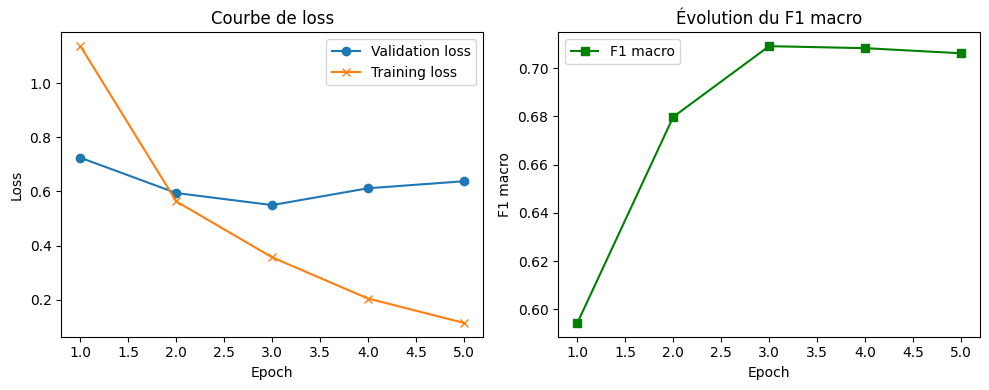


🧪 Error analysis : prédiction sur une phrase concaténée

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 0.80       | ['▁i', 'ṛẓ', 'm', 'n']
imi          | NOUN     | NOUN     | 0.94       | ['▁imi']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
ha           | DET      | DET      | 0.76       | ['▁ha']
wnni         | DET      | DET      | 0.59       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 0.76       | ['▁i', 'ṛẓ', 'm', 'n']
tiṭṭawin     | NOUN     | NOUN     | 0.94       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
acku         | CCONJ    | CCONJ    | 0.68       | ['▁a', 'c', 'ku']
ur           | PART     | PART     | 0.99       | ['▁u', 'r']
jjin         | ADV      | VERB     | 0.92       | ['▁', 'jji', 'n']
ẓṛin         | VERB     | ADP      | 0.81       | ['▁', 'ẓṛ', 'in']


In [ ]:
# === Imports ===
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# === Calcul des poids de classes ===
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# === Tokenizer AfriBERTa ===
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_base")

# === Dataset personnalisé ===
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]
        tokens = self.tokenizer(words, is_split_into_words=True, truncation=True,
                                padding='max_length', max_length=self.max_len, return_tensors="pt")
        word_ids = tokens.word_ids(batch_index=0)
        label_ids = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev:
                label_ids.append(self.tag2id[tags[word_id]])
            else:
                label_ids.append(-100)
            prev = word_id
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': torch.tensor(label_ids)
        }

# === Datasets ===
train_dataset = POSDataset(train_data, tokenizer, tag2id, MAX_LEN)
val_dataset = POSDataset(val_data, tokenizer, tag2id, MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, tag2id, MAX_LEN)

# === Modèle AfriBERTa ===
model = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)

# === Ajout du compute_loss pondéré ===
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model.compute_loss = lambda inputs, return_outputs=False: compute_loss_with_weights(model, inputs, return_outputs)

# === Métriques ===
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    pred_labels, true_labels, flat_pred, flat_true = [], [], [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# === TrainingArguments ===
args = TrainingArguments(
    output_dir="./afriberta-pos-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("./afriberta-pos-weighted")

# === Courbes d'entraînement ===
logs = trainer.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()
for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next(
                (e["loss"] for e in reversed(logs) if "loss" in e and e.get("epoch") == epoch),
                None
            )
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model.device)

    with torch.no_grad():
        output = model(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


## Pré-fine-tuning de AfriBERTa sur 20 datasets de langues africaines puis re-fine-tuning sur le dataset amazigh

### Sans weighting

#### Sans UD mapping

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/29110 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-2762037424.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-2762037424.py:199: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

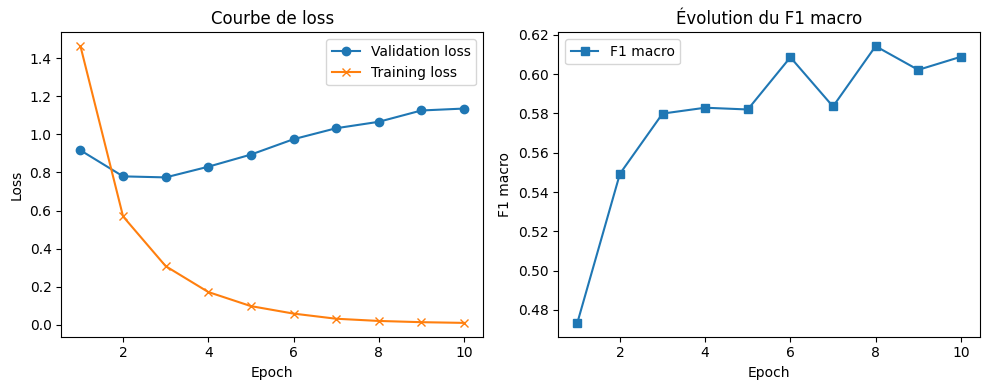


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VBP      | 0.99       | ['▁i', 'ṛẓ', 'm', 'n']
imi          | NN       | NN       | 1.00       | ['▁imi']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
ha           | DT       | DT       | 1.00       | ['▁ha']
wnni         | PDEM     | PDEM     | 0.97       | ['▁w', 'nni']
iṛẓmn        | VBP      | VBP      | 1.00       | ['▁i', 'ṛẓ', 'm', 'n']
tiṭṭawin     | NN       | NN       | 1.00       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
acku         | C        | C        | 1.00       | ['▁a', 'c', 'ku']
ur           | NEG      | NEG      | 1.00       | ['▁u', 'r']
jjin         | ADV      | VB       | 1.00       | ['▁', 'jji', 'n']
ẓṛin         | VB       | ADV      | 0.68       | ['▁',

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
import requests

# === Tokenizer AfriBERTa ===
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_base")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === PRÉ-FINE-TUNING AfriBERTa sur MasakhaPOS ===

def load_conllu_txt(url):
    tokens, tags = [], []
    sentences, pos_tags = [], []
    r = requests.get(url)
    r.encoding = 'utf-8'
    for line in r.text.splitlines():
        line = line.strip()
        if not line:
            if tokens:
                sentences.append(tokens)
                pos_tags.append(tags)
                tokens, tags = [], []
        else:
            parts = line.split()
            if len(parts) == 2:
                tokens.append(parts[0])
                tags.append(parts[1])
    if tokens:
        sentences.append(tokens)
        pos_tags.append(tags)
    return sentences, pos_tags

langs = ["bam", "bbj", "ewe", "fon", "hau", "ibo", "kin", "lug", "luo", "mos",
         "nya", "pcm", "sna", "swh", "tsn", "twi", "wol", "xho", "yor", "zul"]

all_sentences, all_tags = [], []
for lang in langs:
    base = f"https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/data/{lang}"
    for split in ["train.txt", "dev.txt", "test.txt"]:
        sents, tags = load_conllu_txt(f"{base}/{split}")
        all_sentences.extend(sents)
        all_tags.extend(tags)

unique_tags_masakha = sorted(set(tag for seq in all_tags for tag in seq))
tag2id_masakha = {tag: i for i, tag in enumerate(unique_tags_masakha)}
id2tag_masakha = {i: tag for tag, i in tag2id_masakha.items()}

examples_masakha = [{"tokens": s, "tags": t} for s, t in zip(all_sentences, all_tags)]
dataset_masakha = Dataset.from_list(examples_masakha)
dataset_masakha = dataset_masakha.rename_columns({"tokens": "words"})
dataset_masakha = dataset_masakha.map(lambda x: encode_batch(x, tag2id_masakha), batched=True)
dataset_masakha = dataset_masakha.train_test_split(test_size=0.1, seed=42)

model_masakha = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_base", num_labels=len(tag2id_masakha)
)

args_masakha = TrainingArguments(
    output_dir="./afriberta-masakhapos-pre",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_masakha = Trainer(
    model=model_masakha,
    args=args_masakha,
    train_dataset=dataset_masakha["train"],
    eval_dataset=dataset_masakha["test"],
    tokenizer=tokenizer
)

trainer_masakha.train()
trainer_masakha.save_model("./afriberta-masakhapos-pre")

# === RE-FINE-TUNING AfriBERTa sur corpus AMAZIGH ===

examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

model_pretrained = AutoModelForTokenClassification.from_pretrained("./afriberta-masakhapos-pre")
model_amazigh = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)
model_amazigh.roberta.load_state_dict(model_pretrained.roberta.state_dict())

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

args_am = TrainingArguments(
    output_dir="./afriberta-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_amazigh,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./afriberta-amazigh-refinetuned")

# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_amazigh.device)

    with torch.no_grad():
        output = model_amazigh(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/29110 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-26-3435782775.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_masakha = Trainer(


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-26-3435782775.py:164: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

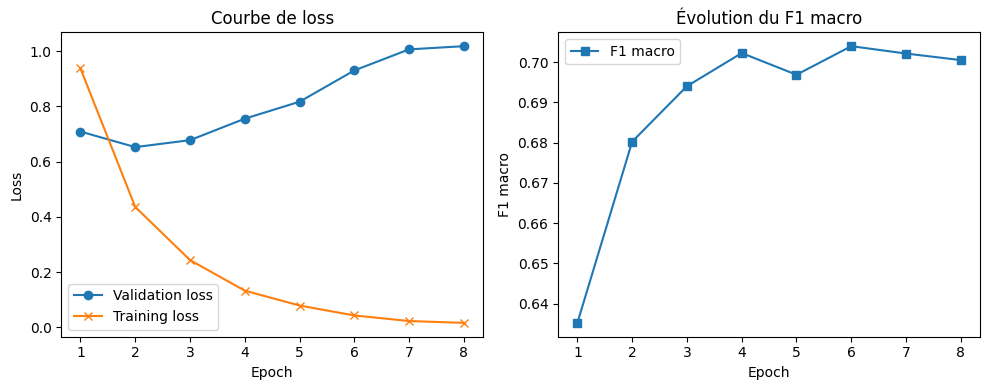


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 1.00       | ['▁i', 'ṛẓ', 'm', 'n']
imi          | NOUN     | NOUN     | 0.99       | ['▁imi']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
ha           | DET      | DET      | 1.00       | ['▁ha']
wnni         | DET      | DET      | 1.00       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 1.00       | ['▁i', 'ṛẓ', 'm', 'n']
tiṭṭawin     | NOUN     | NOUN     | 1.00       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
acku         | CCONJ    | CCONJ    | 1.00       | ['▁a', 'c', 'ku']
ur           | PART     | PART     | 1.00       | ['▁u', 'r']
jjin         | ADV      | VERB     | 1.00       | ['▁', 'jji', 'n']
ẓṛin         | VERB     | ADV      | 0.74       | ['▁',

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
import requests

# === Tokenizer AfriBERTa ===
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_base")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []

    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === PRÉ-FINE-TUNING AfriBERTa sur MasakhaPOS ===

def load_conllu_txt(url):
    tokens, tags = [], []
    sentences, pos_tags = [], []
    r = requests.get(url)
    r.encoding = 'utf-8'
    for line in r.text.splitlines():
        line = line.strip()
        if not line:
            if tokens:
                sentences.append(tokens)
                pos_tags.append(tags)
                tokens, tags = [], []
        else:
            parts = line.split()
            if len(parts) == 2:
                tokens.append(parts[0])
                tags.append(parts[1])
    if tokens:
        sentences.append(tokens)
        pos_tags.append(tags)
    return sentences, pos_tags

langs = ["bam", "bbj", "ewe", "fon", "hau", "ibo", "kin", "lug", "luo", "mos",
         "nya", "pcm", "sna", "swh", "tsn", "twi", "wol", "xho", "yor", "zul"]

all_sentences, all_tags = [], []
for lang in langs:
    base = f"https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/data/{lang}"
    for split in ["train.txt", "dev.txt", "test.txt"]:
        sents, tags = load_conllu_txt(f"{base}/{split}")
        all_sentences.extend(sents)
        all_tags.extend(tags)

unique_tags_masakha = sorted(set(tag for seq in all_tags for tag in seq))
tag2id_masakha = {tag: i for i, tag in enumerate(unique_tags_masakha)}
id2tag_masakha = {i: tag for tag, i in tag2id_masakha.items()}

examples_masakha = [{"tokens": s, "tags": t} for s, t in zip(all_sentences, all_tags)]
dataset_masakha = Dataset.from_list(examples_masakha)
dataset_masakha = dataset_masakha.rename_columns({"tokens": "words"})
dataset_masakha = dataset_masakha.map(lambda x: encode_batch(x, tag2id_masakha), batched=True)
dataset_masakha = dataset_masakha.train_test_split(test_size=0.1, seed=42)

model_masakha = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_base", num_labels=len(tag2id_masakha)
)

args_masakha = TrainingArguments(
    output_dir="./afriberta-masakhapos-pre",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_masakha = Trainer(
    model=model_masakha,
    args=args_masakha,
    train_dataset=dataset_masakha["train"],
    eval_dataset=dataset_masakha["test"],
    tokenizer=tokenizer
)

trainer_masakha.train()
trainer_masakha.save_model("./afriberta-masakhapos-pre")

# === RE-FINE-TUNING AfriBERTa sur corpus AMAZIGH ===

examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

model_pretrained = AutoModelForTokenClassification.from_pretrained("./afriberta-masakhapos-pre")
model_amazigh = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_base",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)
model_amazigh.roberta.load_state_dict(model_pretrained.roberta.state_dict())

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    pred_labels, true_labels = [], []
    flat_pred, flat_true = [], []

    for pred, label in zip(predictions, labels):
        p_seq, t_seq = [], []
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                p_seq.append(id2tag[p_tag])
                t_seq.append(id2tag[l_tag])
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
        pred_labels.append(p_seq)
        true_labels.append(t_seq)

    sentence_accuracy = sum([p == t for p, t in zip(pred_labels, true_labels)]) / len(true_labels)

    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

args_am = TrainingArguments(
    output_dir="./afriberta-amazigh-refinetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_amazigh,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./afriberta-amazigh-refinetuned")

# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)

            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : phrases concaténées ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]

    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt",
                         truncation=True, padding="max_length", max_length=2 * MAX_LEN).to(model_amazigh.device)

    with torch.no_grad():
        output = model_amazigh(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


### Avec weighting

#### Sans UD mapping

Map:   0%|          | 0/29110 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-12-933676935.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-12-933676935.py:172: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

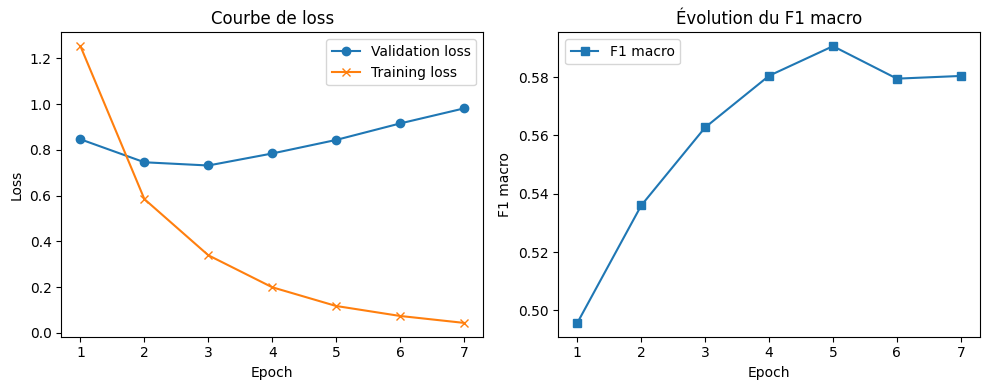


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VBP      | VBP      | 0.96       | ['▁i', 'ṛẓ', 'm', 'n']
imi          | NN       | NN       | 1.00       | ['▁imi']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
ha           | DT       | DT       | 0.97       | ['▁ha']
wnni         | PDEM     | PDEM     | 0.54       | ['▁w', 'nni']
iṛẓmn        | VBP      | VBP      | 0.99       | ['▁i', 'ṛẓ', 'm', 'n']
tiṭṭawin     | NN       | NN       | 1.00       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNC     | PUNC     | 1.00       | ['▁!']
acku         | C        | C        | 0.99       | ['▁a', 'c', 'ku']
ur           | NEG      | NEG      | 1.00       | ['▁u', 'r']
jjin         | ADV      | VB       | 0.99       | ['▁', 'jji', 'n']
ẓṛin         | VB       | VB       | 0.83       | ['▁',

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
import requests
from collections import Counter
from torch.nn import CrossEntropyLoss

# === Paramètres ===
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_base")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []
    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === PRÉ-FINE-TUNING AfriBERTa sur MasakhaPOS ===
def load_conllu_txt(url):
    tokens, tags = [], []
    sentences, pos_tags = [], []
    r = requests.get(url)
    r.encoding = 'utf-8'
    for line in r.text.splitlines():
        line = line.strip()
        if not line:
            if tokens:
                sentences.append(tokens)
                pos_tags.append(tags)
                tokens, tags = [], []
        else:
            parts = line.split()
            if len(parts) == 2:
                tokens.append(parts[0])
                tags.append(parts[1])
    if tokens:
        sentences.append(tokens)
        pos_tags.append(tags)
    return sentences, pos_tags

langs = ["bam", "bbj", "ewe", "fon", "hau", "ibo", "kin", "lug", "luo", "mos",
         "nya", "pcm", "sna", "swh", "tsn", "twi", "wol", "xho", "yor", "zul"]

all_sentences, all_tags = [], []
for lang in langs:
    base = f"https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/data/{lang}"
    for split in ["train.txt", "dev.txt", "test.txt"]:
        sents, tags = load_conllu_txt(f"{base}/{split}")
        all_sentences.extend(sents)
        all_tags.extend(tags)

unique_tags_fr = sorted(set(tag for seq in all_tags for tag in seq))
tag2id_fr = {tag: i for i, tag in enumerate(unique_tags_fr)}
id2tag_fr = {i: tag for tag, i in tag2id_fr.items()}

examples_fr = [{"tokens": s, "tags": t} for s, t in zip(all_sentences, all_tags)]
dataset_fr = Dataset.from_list(examples_fr)
dataset_fr = dataset_fr.rename_columns({"tokens": "words"})
dataset_fr = dataset_fr.map(lambda x: encode_batch(x, tag2id_fr), batched=True)
dataset_fr = dataset_fr.train_test_split(test_size=0.1, seed=42)

model_fr = AutoModelForTokenClassification.from_pretrained("castorini/afriberta_base", num_labels=len(tag2id_fr))

args_fr = TrainingArguments(
    output_dir="./afriberta-masakhapos-pre",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_fr = Trainer(
    model=model_fr,
    args=args_fr,
    train_dataset=dataset_fr["train"],
    eval_dataset=dataset_fr["test"],
    tokenizer=tokenizer
)

trainer_fr.train()
trainer_fr.save_model("./afriberta-masakhapos-pre")

# === RE-FINE-TUNING PONDÉRÉ SUR AMAZIGH ===

# Construction du dataset
examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Calcul des poids de classes
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# Chargement du modèle pré-finetuné et transfert
model_fr_loaded = AutoModelForTokenClassification.from_pretrained("./afriberta-masakhapos-pre")
model_am = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_base",
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)
model_am.roberta.load_state_dict(model_fr_loaded.roberta.state_dict())

# Ajout de la fonction de perte pondérée
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model_am.compute_loss = lambda inputs, return_outputs=False: compute_loss_with_weights(model_am, inputs, return_outputs)

# Métriques
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    flat_pred, flat_true = [], []
    for pred, label in zip(predictions, labels):
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
    sentence_accuracy = sum(p == t for p, t in zip(flat_pred, flat_true)) / len(flat_true)
    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# Entraînement
args_am = TrainingArguments(
    output_dir="./afriberta-amazigh-refinetuned-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./afriberta-amazigh-refinetuned-weighted")

# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : prédiction sur une phrase concaténée ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]
    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True,
                         padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)


#### Avec UD mapping

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

Map:   0%|          | 0/29110 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-933676935.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fr = Trainer(


model.safetensors:   0%|          | 0.00/446M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: hmidou-perso (hmidou-perso-universit-internationale-de-rabat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-933676935.py:172: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_am = Trainer(


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

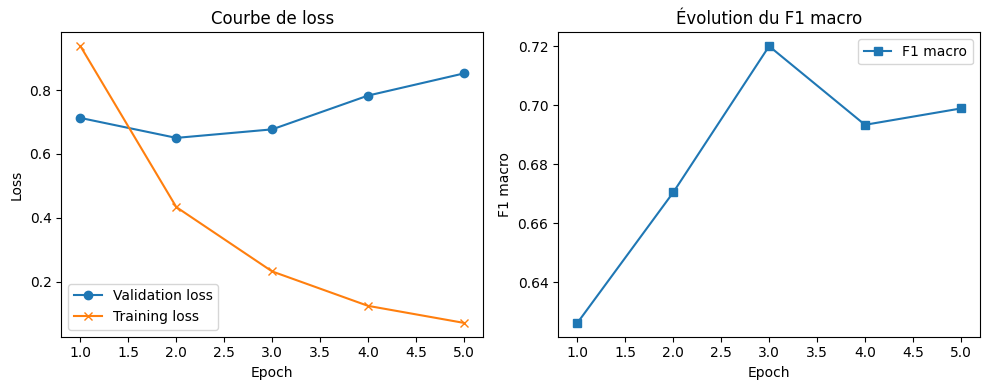


🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)

--- Phrase concaténée ---
Word         | Vrai     | Prédit   | Confiance  | Sous-tokens
----------------------------------------------------------------------
iṛẓmn        | VERB     | VERB     | 0.96       | ['▁i', 'ṛẓ', 'm', 'n']
imi          | NOUN     | NOUN     | 0.96       | ['▁imi']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
ha           | DET      | DET      | 0.67       | ['▁ha']
wnni         | DET      | DET      | 0.73       | ['▁w', 'nni']
iṛẓmn        | VERB     | VERB     | 0.99       | ['▁i', 'ṛẓ', 'm', 'n']
tiṭṭawin     | NOUN     | NOUN     | 0.99       | ['▁ti', 'ṭṭ', 'a', 'win']
!            | PUNCT    | PUNCT    | 1.00       | ['▁!']
acku         | CCONJ    | CCONJ    | 0.99       | ['▁a', 'c', 'ku']
ur           | PART     | PART     | 1.00       | ['▁u', 'r']
jjin         | ADV      | VERB     | 0.65       | ['▁', 'jji', 'n']
ẓṛin         | VERB     | VERB     | 0.38       | ['▁',

In [ ]:
# === Imports ===
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
import requests
from collections import Counter
from torch.nn import CrossEntropyLoss

# === Paramètres ===
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_base")

# === Fonction d'encodage générique ===
def encode_batch(batch, tag2id):
    tokenized = tokenizer(batch["words"], is_split_into_words=True, padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = []
    for i in range(len(batch["words"])):
        word_ids = tokenized.word_ids(batch_index=i)
        label = []
        prev = None
        for word_id in word_ids:
            if word_id is None:
                label.append(-100)
            elif word_id != prev:
                label.append(tag2id[batch["tags"][i][word_id]])
            else:
                label.append(-100)
            prev = word_id
        labels.append(label)
    tokenized["labels"] = labels
    return tokenized

# === PRÉ-FINE-TUNING AfriBERTa sur MasakhaPOS ===
def load_conllu_txt(url):
    tokens, tags = [], []
    sentences, pos_tags = [], []
    r = requests.get(url)
    r.encoding = 'utf-8'
    for line in r.text.splitlines():
        line = line.strip()
        if not line:
            if tokens:
                sentences.append(tokens)
                pos_tags.append(tags)
                tokens, tags = [], []
        else:
            parts = line.split()
            if len(parts) == 2:
                tokens.append(parts[0])
                tags.append(parts[1])
    if tokens:
        sentences.append(tokens)
        pos_tags.append(tags)
    return sentences, pos_tags

langs = ["bam", "bbj", "ewe", "fon", "hau", "ibo", "kin", "lug", "luo", "mos",
         "nya", "pcm", "sna", "swh", "tsn", "twi", "wol", "xho", "yor", "zul"]

all_sentences, all_tags = [], []
for lang in langs:
    base = f"https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/data/{lang}"
    for split in ["train.txt", "dev.txt", "test.txt"]:
        sents, tags = load_conllu_txt(f"{base}/{split}")
        all_sentences.extend(sents)
        all_tags.extend(tags)

unique_tags_fr = sorted(set(tag for seq in all_tags for tag in seq))
tag2id_fr = {tag: i for i, tag in enumerate(unique_tags_fr)}
id2tag_fr = {i: tag for tag, i in tag2id_fr.items()}

examples_fr = [{"tokens": s, "tags": t} for s, t in zip(all_sentences, all_tags)]
dataset_fr = Dataset.from_list(examples_fr)
dataset_fr = dataset_fr.rename_columns({"tokens": "words"})
dataset_fr = dataset_fr.map(lambda x: encode_batch(x, tag2id_fr), batched=True)
dataset_fr = dataset_fr.train_test_split(test_size=0.1, seed=42)

model_fr = AutoModelForTokenClassification.from_pretrained("castorini/afriberta_base", num_labels=len(tag2id_fr))

args_fr = TrainingArguments(
    output_dir="./afriberta-masakhapos-pre",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1
)

trainer_fr = Trainer(
    model=model_fr,
    args=args_fr,
    train_dataset=dataset_fr["train"],
    eval_dataset=dataset_fr["test"],
    tokenizer=tokenizer
)

trainer_fr.train()
trainer_fr.save_model("./afriberta-masakhapos-pre")

# === RE-FINE-TUNING PONDÉRÉ SUR AMAZIGH ===

# Construction du dataset
examples_am = [{"tokens": w, "tags": t} for w, t in train_data + val_data + test_data]
dataset_am = Dataset.from_list(examples_am).train_test_split(test_size=0.2)
dataset_am = dataset_am.rename_columns({"tokens": "words"})
dataset_am = dataset_am.map(lambda x: encode_batch(x, tag2id), batched=True)

# Calcul des poids de classes
tag_counts = Counter(tag for _, tags in train_data for tag in tags)
total = sum(tag_counts.values())
class_weights = torch.tensor([total / tag_counts[tag] for tag in tag2id.keys()], dtype=torch.float)

# Chargement du modèle pré-finetuné et transfert
model_fr_loaded = AutoModelForTokenClassification.from_pretrained("./afriberta-masakhapos-pre")
model_am = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_base",
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)
model_am.roberta.load_state_dict(model_fr_loaded.roberta.state_dict())

# Ajout de la fonction de perte pondérée
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device), ignore_index=-100)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

model_am.compute_loss = lambda inputs, return_outputs=False: compute_loss_with_weights(model_am, inputs, return_outputs)

# Métriques
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    flat_pred, flat_true = [], []
    for pred, label in zip(predictions, labels):
        for p_tag, l_tag in zip(pred, label):
            if l_tag != -100:
                flat_pred.append(id2tag[p_tag])
                flat_true.append(id2tag[l_tag])
    sentence_accuracy = sum(p == t for p, t in zip(flat_pred, flat_true)) / len(flat_true)
    return {
        "accuracy": accuracy_score(flat_true, flat_pred),
        "f1_macro": f1_score(flat_true, flat_pred, average="macro"),
        "f1_weighted": f1_score(flat_true, flat_pred, average="weighted"),
        "sentence_accuracy": sentence_accuracy
    }

# Entraînement
args_am = TrainingArguments(
    output_dir="./afriberta-amazigh-refinetuned-weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=10,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

trainer_am = Trainer(
    model=model_am,
    args=args_am,
    train_dataset=dataset_am["train"],
    eval_dataset=dataset_am["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_am.train()
trainer_am.save_model("./afriberta-amazigh-refinetuned-weighted")

# === Courbes d'entraînement ===
logs = trainer_am.state.log_history
train_loss, eval_loss, eval_f1, epochs = [], [], [], []
seen_epochs = set()

for entry in logs:
    if "eval_loss" in entry:
        epoch = entry["epoch"]
        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            eval_loss.append(entry["eval_loss"])
            eval_f1.append(entry.get("eval_f1_macro", None))
            epochs.append(epoch)
            matching_train_loss = next((e["loss"] for e in reversed(logs)
                                        if "loss" in e and e.get("epoch") == epoch), None)
            train_loss.append(matching_train_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_loss, label="Validation loss", marker='o')
plt.plot(epochs, train_loss, label="Training loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_f1, label="F1 macro", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("Évolution du F1 macro")
plt.legend()
plt.tight_layout()
plt.show()

# === Error analysis : prédiction sur une phrase concaténée ===
print("\n🧪 Error analysis : prédiction sur une phrase concaténée (2× MAX_LEN)")
random.seed(4231994)
pairs = random.sample(range(len(test_data) - 1), 5)

for idx in pairs:
    words = test_data[idx][0] + test_data[idx + 1][0]
    true_tags = test_data[idx][1] + test_data[idx + 1][1]
    encoding = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True,
                         padding="max_length", max_length=2 * MAX_LEN).to(model_am.device)

    with torch.no_grad():
        output = model_am(**encoding)
        logits_i = output.logits.squeeze(0)
        probs_i = F.softmax(logits_i, dim=-1)
        preds_i = torch.argmax(probs_i, dim=-1).cpu().tolist()
        confs = torch.max(probs_i, dim=-1).values.cpu().tolist()

    word_ids = encoding.word_ids()
    seen = set()
    print("\n--- Phrase concaténée ---")
    print(f"{'Word':<12} | {'Vrai':<8} | {'Prédit':<8} | {'Confiance':<10} | Sous-tokens")
    print("-" * 70)
    for j, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in seen or j >= len(preds_i):
            continue
        true = true_tags[word_idx]
        pred = id2tag[preds_i[j]]
        conf = confs[j]
        sub_tokens = tokenizer.tokenize(words[word_idx])
        print(f"{words[word_idx]:<12} | {true:<8} | {pred:<8} | {conf:<10.2f} | {sub_tokens}")
        seen.add(word_idx)
